### [1] Requirements
Import dependencies and configure the notebook runtime.

In [75]:
# [3]

import re
import os, json, math, random
from pathlib import Path
import numpy as np
import pandas as pd
from tifffile import imread, imwrite, TiffFile
from skimage import filters, exposure, transform, feature, measure, registration, img_as_float32
from skimage.transform import SimilarityTransform, AffineTransform, warp
from skimage.util import img_as_ubyte
from scipy import ndimage as ndi

# Optional OpenCV (accelerated NCC); guarded import
try:
    import cv2
    HAS_CV2 = True
except Exception:
    HAS_CV2 = False

import matplotlib.pyplot as plt

print("HAS_CV2:", HAS_CV2)

HAS_CV2: True


### [2] Paths & I/O
Set dataset roots, infer key file paths, and prepare output dirs.

In [76]:
# [5]
# --- Paths (auto-discovered) ---
from pathlib import Path

NAS_ROOT = Path('/Volumes/jlarsch/default/D2c/07_Data')
OWNER = 'Danin'
FISH_ID = 'L395_f11'


def owner_root(nas_root, owner):
    base = nas_root / owner
    mic = base / 'Microscopy'
    return mic if mic.exists() else base


FISH_DIR = owner_root(NAS_ROOT, OWNER) / FISH_ID
ANALYSIS_DIR = FISH_DIR / '03_analysis'
OUTDIR = ANALYSIS_DIR / 'functional'
REF_DIR = OUTDIR / 'reference_planes'
OUTDIR.mkdir(parents=True, exist_ok=True)
REF_DIR.mkdir(parents=True, exist_ok=True)

TMP_CONVERT_DIR = OUTDIR / 'converted_nrrd_to_tif'
TMP_CONVERT_DIR.mkdir(parents=True, exist_ok=True)


def first_match(globs, desc, all_hits=False):
    hits_all = []
    for g in globs:
        hits = sorted(FISH_DIR.glob(g))
        hits_all.extend(hits)
    if all_hits:
        if not hits_all:
            print(f"[WARN] No match for {desc} (patterns: {globs})")
        return hits_all
    if hits_all:
        return hits_all[0]
    print(f"[WARN] No match for {desc} (patterns: {globs})")
    return None


# Locate unflipped functional stacks and anatomy stack
FUNC_NONFLIPPED_LIST = first_match(['02_reg/00_preprocessing/2p_functional/02_motionCorrected/*mcorrected*.tif'], 'functional stack(s) (unflipped)', all_hits=True)
ANAT_STACK_PATH = first_match(['02_reg/00_preprocessing/2p_anatomy/*_anatomy_2P_GCaMP.*'], 'anatomy stack')
HCR_STACK_PATH = None

# Flipped functional output paths (one per input)
FLIPPED_LIST = []
for p in FUNC_NONFLIPPED_LIST:
    FLIPPED_LIST.append(OUTDIR / f"{Path(p).stem}_flipX.tif")

FUNC_LABELS_PATH = None
ANAT_LABELS_PATH = None
HCR_LABELS_PATH = None
HCR_LABELS_PATHS = []


def infer_anat_labels_path(fish_dir, fish_id):
    cand_dirs = [
        fish_dir / '03_analysis' / 'structural' / 'cp_masks',
        fish_dir / '03_analysis' / 'functional' / 'masks',
    ]
    patterns = [
        f"*{fish_id}*anatomy*cp_masks*.tif",
        f"*{fish_id}*cp_masks*.tif",
        '*anatomy*cp_masks*.tif',
        '*cp_masks*.tif',
    ]
    for d in cand_dirs:
        if not d.exists():
            continue
        for pat in patterns:
            hits = sorted(d.glob(pat))
            if hits:
                return hits[0]
    return None


def infer_hcr_label_paths(fish_dir, fish_id):
    d = fish_dir / '03_analysis' / 'confocal' / 'cp_masks'
    if not d.exists():
        return []
    patterns = [
        f"{fish_id}_round*_cp_masks*.tif",
        f"{fish_id}_round*.tif",
        "*round*_cp_masks*.tif",
    ]
    hits = []
    for pat in patterns:
        hits.extend(sorted(d.glob(pat)))
    uniq = []
    seen = set()
    for h in hits:
        if h not in seen:
            uniq.append(h)
            seen.add(h)
    return uniq





if ANAT_LABELS_PATH is None:
    auto_anat_lbl = infer_anat_labels_path(FISH_DIR, FISH_ID)
    if auto_anat_lbl:
        ANAT_LABELS_PATH = auto_anat_lbl
        print(f"[Paths] Using inferred ANAT_LABELS_PATH: {ANAT_LABELS_PATH}")
    else:
        print('[Paths] Could not infer ANAT_LABELS_PATH automatically; set ANAT_LABELS_PATH manually if available.')
else:
    print(f"[Paths] Using provided ANAT_LABELS_PATH: {ANAT_LABELS_PATH}")


if not HCR_LABELS_PATHS:
    auto_hcr_lbls = infer_hcr_label_paths(FISH_DIR, FISH_ID)
    if auto_hcr_lbls:
        HCR_LABELS_PATHS = auto_hcr_lbls
        if HCR_LABELS_PATH is None and HCR_LABELS_PATHS:
            HCR_LABELS_PATH = HCR_LABELS_PATHS[0]
        print(f"[Paths] Using inferred HCR_LABELS_PATHS (n={len(HCR_LABELS_PATHS)}):")
        for p in HCR_LABELS_PATHS:
            print('  ', p)
    else:
        if HCR_LABELS_PATH:
            HCR_LABELS_PATHS = [HCR_LABELS_PATH]
            print(f"[Paths] Using provided HCR_LABELS_PATH: {HCR_LABELS_PATH}")
        else:
            print('[Paths] Could not infer HCR_LABELS_PATHS automatically; set HCR_LABELS_PATH(S) manually if available.')
elif HCR_LABELS_PATHS and HCR_LABELS_PATH is None:
    HCR_LABELS_PATH = HCR_LABELS_PATHS[0]
    print(f"[Paths] Using provided HCR_LABELS_PATHS (n={len(HCR_LABELS_PATHS)}); default HCR_LABELS_PATH = {HCR_LABELS_PATH}")

# Behavior flags
FUNC_FLIP_X = True  # always flip functional to match anatomy orientation
REF_BUILD_STRATEGY = 'time_mean'
RESCALE_FOR_NCC = False
OVERWRITE_FLIPPED = False  # overwrite flipped stacks if they already exist (avoid stale data)
REUSE_SAVED_REFS = True  # reuse cached ref images if present (set False to rebuild like legacy)
MAX_FRAMES_FOR_REF = 1000
VOX_FUNC_MANUAL = { 'X': 0.6166852, 'Y': 0.6166852 }
VOX_ANAT_MANUAL = { 'X': 0.5964025, 'Y': 0.5964025, 'Z': 2.0 }
VOX_HCR_MANUAL = { 'X': 0.3279636, 'Y': 0.3279636, 'Z': 3 }
VOX_CACHE_PATH = OUTDIR / 'voxel_sizes.json'

RNG_SEED = 42
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)
WARP_HCR_INTENSITY_QC = globals().get("WARP_HCR_INTENSITY_QC", False)
HCR_INTENSITY_PATHS = globals().get("HCR_INTENSITY_PATHS", None)



[Paths] Using inferred ANAT_LABELS_PATH: /Volumes/jlarsch/default/D2c/07_Data/Danin/L395_f11/03_analysis/structural/cp_masks/L395_f11_anatomy_00001_8bit_cp_masks.tif
[Paths] Using inferred HCR_LABELS_PATHS (n=4):
   /Volumes/jlarsch/default/D2c/07_Data/Danin/L395_f11/03_analysis/confocal/cp_masks/L395_f11_round1_channel2_sst1_1_cp_masks.tif
   /Volumes/jlarsch/default/D2c/07_Data/Danin/L395_f11/03_analysis/confocal/cp_masks/L395_f11_round1_channel3_pth2_cp_masks.tif
   /Volumes/jlarsch/default/D2c/07_Data/Danin/L395_f11/03_analysis/confocal/cp_masks/L395_f11_round2_channel2_sst1_2_cp_masks.tif
   /Volumes/jlarsch/default/D2c/07_Data/Danin/L395_f11/03_analysis/confocal/cp_masks/L395_f11_round2_channel3_tac3b_cp_masks.tif


### [3] Utility functions
Helper routines for image I/O, transforms, voxel inference, and measurements.

In [77]:
# [7]
def imread_any(path):
    p = Path(path)
    ext = p.suffix.lower()
    if ext == '.nrrd':
        try:
            import nrrd
            data, _ = nrrd.read(str(p))
            return np.asarray(data)
        except Exception:
            try:
                import SimpleITK as sitk
                data = sitk.GetArrayFromImage(sitk.ReadImage(str(p)))
                return np.asarray(data)
            except Exception as e_sitk:
                raise ImportError('Reading .nrrd requires pynrrd or SimpleITK') from e_sitk
    return imread(path)


def zproject_mean(stack):
    return stack.mean(axis=0)

def norm01(img):
    img = img.astype(np.float32)
    m, M = np.percentile(img, (1, 99))
    if M <= m:
        M = img.max(); m = img.min()
    out = np.clip((img - m) / (M - m + 1e-6), 0, 1)
    return out

def local_unsharp(img, blur_sigma=1.0, amount=0.6):
    base = ndi.gaussian_filter(img, blur_sigma)
    return np.clip(base + amount*(img - base), 0, 1)

def corrcoef_img(a, b):
    # Pearson correlation between 2D arrays
    a = a.astype(np.float32); b = b.astype(np.float32)
    am = a.mean(); bm = b.mean()
    num = ((a - am)*(b - bm)).sum()
    den = np.sqrt(((a - am)**2).sum() * ((b - bm)**2).sum()) + 1e-8
    return float(num / den)

def top_correlated_mean(stack_t, take_k=20, pre_smooth_sigma=0.5):
    """Suite2p-like: build crisp reference by selecting top-K frames most correlated to a provisional mean."""
    T, H, W = stack_t.shape
    # Provisional mean
    m0 = stack_t.mean(axis=0)
    # Optional pre-smoothing to reduce shot noise
    if pre_smooth_sigma and pre_smooth_sigma > 0:
        m0s = ndi.gaussian_filter(m0, pre_smooth_sigma)
    else:
        m0s = m0
    # Correlate each frame with provisional mean
    corrs = np.empty(T, dtype=np.float32)
    for i in range(T):
        fi = stack_t[i]
        if pre_smooth_sigma and pre_smooth_sigma > 0:
            fi = ndi.gaussian_filter(fi, pre_smooth_sigma)
        corrs[i] = corrcoef_img(fi, m0s)
    # Take top-K
    k = min(take_k, T)
    idx = np.argsort(corrs)[-k:]
    ref = stack_t[idx].mean(axis=0)
    return ref, idx, corrs

def best_z_by_ncc(template, anat_stack, use_cv2=True):
    """Return best Z index and NCC scores over Z for a 2D template vs 3D stack."""
    template = norm01(template)
    H, W = template.shape
    scores = []
    if use_cv2 and HAS_CV2:
        templ = (template*255).astype(np.uint8)
        for z in range(anat_stack.shape[0]):
            sl = norm01(anat_stack[z])
            sl8 = (sl*255).astype(np.uint8)
            res = cv2.matchTemplate(sl8, templ, cv2.TM_CCORR_NORMED)
            # Whole-image match: template same size; if not, pad template or crop; here we assume same FOV/size
            if res.size == 1:
                s = float(res.ravel()[0])
            else:
                s = float(res.max())
            scores.append(s)
    else:
        # fallback: simple correlation on same-size images
        for z in range(anat_stack.shape[0]):
            sl = norm01(anat_stack[z])
            s = corrcoef_img(template, sl)
            scores.append(s)
    scores = np.asarray(scores, dtype=np.float32)
    best_z = int(np.argmax(scores))
    return best_z, scores

def estimate_inplane_transform(mov, ref, method='similarity'):
    """Estimate 2D transform from moving image (mov) to reference (ref).
    Tries ORB+RANSAC; falls back to phase cross-correlation (shift only)."""
    m = norm01(mov); r = norm01(ref)
    # ORB keypoints
    try:
        detector = feature.ORB(n_keypoints=2000, fast_threshold=0.05)
        detector.detect_and_extract(img_as_float32(m))
        kp1 = detector.keypoints; d1 = detector.descriptors
        detector.detect_and_extract(img_as_float32(r))
        kp2 = detector.keypoints; d2 = detector.descriptors
        if len(kp1) >= 10 and len(kp2) >= 10 and d1 is not None and d2 is not None:
            matches12 = feature.match_descriptors(d1, d2, cross_check=True, max_ratio=0.8)
            src = kp1[matches12[:, 0]][:, ::-1]  # (x,y)
            dst = kp2[matches12[:, 1]][:, ::-1]
            if method == 'similarity':
                model, inliers = measure.ransac((src, dst), SimilarityTransform,
                                                min_samples=3, residual_threshold=2.0, max_trials=2000)
            else:
                model, inliers = measure.ransac((src, dst), AffineTransform,
                                                min_samples=3, residual_threshold=2.0, max_trials=2000)
            if model is not None:
                return model
    except Exception as e:
        pass
    # Fallback: phase correlation for shift
    shift, _, _ = registration.phase_cross_correlation(r, m, upsample_factor=10)
    tform = SimilarityTransform(translation=(shift[1], shift[0]))
    return tform

def refine_affine_ecc(mov, ref, init_tform=None, max_iters=200, eps=1e-6, pyr_levels=3):
    """Refine an in-plane transform with OpenCV ECC (intensity-based), using affine model.
    Returns an AffineTransform that maps mov → ref.
    Strategy: pre-warp mov with init_tform into ref-shape, then run ECC starting from identity; compose.
    """
    if not HAS_CV2:
        return init_tform if init_tform is not None else AffineTransform()
    r = img_as_float32(norm01(ref))
    # Pre-warp moving with init transform to match ref shape (if provided)
    if init_tform is None:
        m0 = img_as_float32(norm01(mov))
        if m0.shape != r.shape:
            m0 = transform.resize(m0, r.shape, order=1, preserve_range=True, anti_aliasing=True).astype(np.float32)
        W_init = np.eye(3, dtype=np.float32)
    else:
        m0 = apply_transform_2d(img_as_float32(norm01(mov)), init_tform, output_shape=r.shape, order=1)
        W_init = init_tform.params.astype(np.float32)
    # ECC from identity
    W_ecc = np.eye(2, 3, dtype=np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, int(max_iters), float(eps))
    try:
        cc, Wopt = cv2.findTransformECC(r, m0, W_ecc, cv2.MOTION_AFFINE, criteria, None, pyr_levels)
        A_ecc = np.eye(3, dtype=np.float32); A_ecc[:2, :]= Wopt
        # Compose: first init, then ECC refinement in ref frame
        A_final = A_ecc @ W_init
        return AffineTransform(matrix=A_final)
    except Exception:
        return init_tform if init_tform is not None else AffineTransform()

def apply_transform_2d(img, tform, output_shape=None, order=1, preserve_range=True):
    if output_shape is None:
        output_shape = img.shape
    warped = warp(img, inverse_map=tform.inverse, output_shape=output_shape, order=order,
                  preserve_range=preserve_range, mode='constant', cval=0.0, clip=True)
    return warped

def resample_labels_nn(img, tform, output_shape=None):
    # nearest-neighbor for label images
    return apply_transform_2d(img, tform, output_shape=output_shape, order=0, preserve_range=True)

def apply_anat_to_hcr_warp_2d(slice_img, z_index, warp3d_func):
    """Hook to apply a 3D warp (anatomy→HCR) to a 2D slice.
    `warp3d_func` should accept (z,y,x) indices or coordinates and return warped image in HCR coords.
    For now this is a placeholder you can implement with your BigWarp/ANTs output.
    """
    return warp3d_func(slice_img, z_index)

def quickshow(img, title='', vmin=None, vmax=None):
    plt.figure(figsize=(5,5))
    plt.imshow(img, vmin=vmin, vmax=vmax)
    plt.title(title); plt.axis('off'); plt.show()

def _to_um(val, unit):
    try:
        v = float(val)
    except Exception:
        return None
    if unit is None:
        return None
    u = str(unit).lower()
    if u in ('µm', 'um', 'micron', 'micrometer', 'micrometre'):
        return v
    if u in ('nm', 'nanometer', 'nanometre'):
        return v / 1000.0
    if u in ('mm', 'millimeter', 'millimetre'):
        return v * 1000.0
    if u in ('cm', 'centimeter', 'centimetre'):
        return v * 10000.0
    if u in ('in', 'inch', 'inches'):
        return v * 25400.0
    return None

def _res_to_um_per_px(res_tag, unit_tag):
    try:
        num, den = getattr(res_tag, 'value', (None, None))
        if num is None or den is None:
            v = float(getattr(res_tag, 'value', None))
            ppu = v
        else:
            ppu = float(num) / float(den)
    except Exception:
        return None
    unit_val = getattr(unit_tag, 'value', unit_tag)
    try:
        u = str(unit_val).upper()
    except Exception:
        u = 'NONE'
    if u == '2' or 'INCH' in u:
        return 25400.0 / ppu
    if u == '3' or 'CENTIMETER' in u or 'CM' in u:
        return 10000.0 / ppu
    return None

def infer_voxels_tiff(path):
    vox = {'Z': None, 'Y': None, 'X': None}
    try:
        with TiffFile(str(path)) as tf:
            # OME-XML
            omexml = None
            try:
                omexml = tf.ome_metadata
            except Exception:
                omexml = None
            if omexml:
                try:
                    import xml.etree.ElementTree as ET
                    root = ET.fromstring(omexml)
                    # find any Pixels element regardless of namespace
                    pix = root.find('.//{*}Pixels')
                    if pix is not None:
                        px = pix.attrib.get('PhysicalSizeX'); pxu = pix.attrib.get('PhysicalSizeXUnit')
                        py = pix.attrib.get('PhysicalSizeY'); pyu = pix.attrib.get('PhysicalSizeYUnit')
                        pz = pix.attrib.get('PhysicalSizeZ'); pzu = pix.attrib.get('PhysicalSizeZUnit')
                        if py is not None:
                            v = _to_um(py, pyu or 'um')
                            if v: vox['Y'] = v
                        if px is not None:
                            v = _to_um(px, pxu or 'um')
                            if v: vox['X'] = v
                        if pz is not None:
                            v = _to_um(pz, pzu or 'um')
                            if v: vox['Z'] = v
                except Exception:
                    pass
            # ImageJ metadata (Z spacing)
            try:
                ij = tf.imagej_metadata or {}
                if isinstance(ij, dict):
                    zsp = ij.get('spacing', None)
                    unit = ij.get('unit', 'um')
                    if vox['Z'] is None and zsp is not None:
                        vz = _to_um(zsp, unit)
                        if vz: vox['Z'] = vz
            except Exception:
                pass
            # Resolution tags → X/Y
            try:
                page0 = tf.pages[0]
                xr = page0.tags.get('XResolution', None)
                yr = page0.tags.get('YResolution', None)
                ru = page0.tags.get('ResolutionUnit', None)
                if vox['X'] is None and xr is not None and ru is not None:
                    vx = _res_to_um_per_px(xr, ru)
                    if vx: vox['X'] = vx
                if vox['Y'] is None and yr is not None and ru is not None:
                    vy = _res_to_um_per_px(yr, ru)
                    if vy: vox['Y'] = vy
            except Exception:
                pass
            # Parse ImageDescription for XY pixel size if still missing
            try:
                page0 = tf.pages[0]
                desc = None
                try:
                    desc = page0.description
                except Exception:
                    pass
                if desc is None:
                    try:
                        tag = page0.tags.get('ImageDescription', None)
                        desc = getattr(tag, 'value', None)
                    except Exception:
                        desc = None
                if desc is not None:
                    try:
                        text = desc.decode('utf-8', 'ignore') if isinstance(desc, (bytes, bytearray)) else str(desc)
                    except Exception:
                        text = str(desc)
                    kv = {}
                    for line in text.replace('\r', '\n').split('\n'):
                        if '=' in line:
                            k, v = line.split('=', 1)
                            kv[k.strip()] = v.strip()
                    unit = kv.get('unit', kv.get('Unit', 'um'))
                    px = kv.get('pixelWidth') or kv.get('PixelWidth') or kv.get('XPixelSize') or kv.get('micronsPerPixelX') or kv.get('MicronsPerPixelX') or kv.get('umPerPixelX') or kv.get('UmPerPixelX') or kv.get('X_UM_PER_PIXEL')
                    py = kv.get('pixelHeight') or kv.get('PixelHeight') or kv.get('YPixelSize') or kv.get('micronsPerPixelY') or kv.get('MicronsPerPixelY') or kv.get('umPerPixelY') or kv.get('UmPerPixelY') or kv.get('Y_UM_PER_PIXEL')
                    both = kv.get('PixelSizeUm') or kv.get('pixelSizeUm') or kv.get('PixelSize')
                    if both is not None:
                        try:
                            val = float(both)
                            if vox['X'] is None: vox['X'] = val
                            if vox['Y'] is None: vox['Y'] = val
                        except Exception:
                            pass
                    if vox['X'] is None and px is not None:
                        vx = _to_um(px, unit)
                        if vx: vox['X'] = vx
                    if vox['Y'] is None and py is not None:
                        vy = _to_um(py, unit)
                        if vy: vox['Y'] = vy
            except Exception:
                pass
    except Exception:
        pass
    # 5) Final fallback: try ANTs (as in antsQC) if available; works for NRRD/TIFF and reads spacing header
    try:
        import ants  # type: ignore
        img = ants.image_read(str(path))
        sp = tuple(float(s) for s in img.spacing)  # (dx,dy[,dz])
        if len(sp) >= 2:
            if vox['X'] is None: vox['X'] = sp[0]*1.0  # dx (µm)
            if vox['Y'] is None: vox['Y'] = sp[1]*1.0  # dy (µm)
        if len(sp) >= 3 and vox['Z'] is None:
            vox['Z'] = sp[2]*1.0  # dz (µm)
    except Exception:
        pass
    return vox

def load_or_cache_voxels(path, alias):
    cache = {}
    if VOX_CACHE_PATH.exists():
        try:
            with open(VOX_CACHE_PATH, 'r') as f:
                cache = json.load(f)
        except Exception:
            cache = {}
    by_path = cache.get('by_path', {})
    pkey = str(Path(path))
    if pkey in by_path:
        cached = by_path[pkey]
        # If cached entry is incomplete, try to re-infer now
        try:
            incomplete = cached is None or any(cached.get(ax) is None for ax in ('X','Y','Z'))
        except Exception:
            incomplete = True
        if not incomplete:
            return cached
        # Re-infer and update cache
        vox = infer_voxels_tiff(path)
        cache['by_path'][pkey] = vox
        cache.setdefault('by_alias', {})[alias] = vox
        try:
            with open(VOX_CACHE_PATH, 'w') as f:
                json.dump(cache, f, indent=2)
        except Exception:
            pass
        return vox
    vox = infer_voxels_tiff(path)
    cache.setdefault('by_path', {})[pkey] = vox
    cache.setdefault('by_alias', {})[alias] = vox
    try:
        with open(VOX_CACHE_PATH, 'w') as f:
            json.dump(cache, f, indent=2)
    except Exception:
        pass
    return vox

def rescale_to_match_xy(img, vox_src, vox_dst, order=1):
    try:
        sy = float(vox_src.get('Y')) / float(vox_dst.get('Y'))
        sx = float(vox_src.get('X')) / float(vox_dst.get('X'))
    except Exception:
        return img
    if not np.isfinite(sy) or not np.isfinite(sx):
        return img
    if abs(sy - 1.0) < 1e-3 and abs(sx - 1.0) < 1e-3:
        return img
    out_shape = (max(1, int(round(img.shape[0] * sy))), max(1, int(round(img.shape[1] * sx))))
    return transform.resize(img, out_shape, order=order, preserve_range=True, anti_aliasing=True).astype(np.float32)    

def _ensure_uint_labels(arr):
    arr = np.asarray(arr)
    if not np.issubdtype(arr.dtype, np.integer):
        arr = arr.astype(np.int64)
    return arr

def _regionprops_centroids_2d(label_img):
    tbl = measure.regionprops_table(label_img, properties=['label', 'centroid'])
    df = pd.DataFrame(tbl).rename(columns={'centroid-0': 'cy', 'centroid-1': 'cx'})
    df = df[df['label'] != 0].reset_index(drop=True)
    return df

def _apply_tform_points_xy(tform, x, y):
    pts = np.stack([x, y], axis=1)
    pts_t = tform(pts)
    return pts_t[:,0], pts_t[:,1]

def diameters_um_from_array(arr, vox, axis_order=('Z','Y','X')):
    """Compute per-label diameters along Z/Y/X in µm from a 3D label array.
    Expects vox like {'Z': dz, 'Y': dy, 'X': dx}.
    """
    from skimage.measure import regionprops_table
    arr = np.asarray(arr)
    if arr.ndim != 3:
        raise ValueError('diameters_um_from_array expects a 3D label array (Z,Y,X)')
    props = regionprops_table(arr, properties=('label','bbox'))
    df = pd.DataFrame(props)
    if df.empty:
        return pd.DataFrame(columns=['label','z_um','y_um','x_um'])
    df = df.rename(columns={
        'bbox-0':'zmin','bbox-1':'ymin','bbox-2':'xmin',
        'bbox-3':'zmax','bbox-4':'ymax','bbox-5':'xmax'
    })
    dz = float(vox.get('Z', 1.0)); dy = float(vox.get('Y', 1.0)); dx = float(vox.get('X', 1.0))
    df['z_um'] = (df['zmax'] - df['zmin']) * dz
    df['y_um'] = (df['ymax'] - df['ymin']) * dy
    df['x_um'] = (df['xmax'] - df['xmin']) * dx
    df = df[['label','z_um','y_um','x_um']].copy()
    df['label'] = df['label'].astype(int)
    return df

In [78]:
# HCR matching/QC helpers (antsQC-style)

import numpy as _np
import pandas as _pd
from scipy.spatial import cKDTree as _cKDTree
from scipy.optimize import linear_sum_assignment as _lsa


def compute_centroids(mask):
    props = regionprops_table(mask, properties=("label", "centroid"))
    df = _pd.DataFrame(props)
    df = df.rename(columns={"centroid-0": "z", "centroid-1": "y", "centroid-2": "x"})
    df = df[df["label"] != 0].reset_index(drop=True)
    return df


def idx_to_um(df, vox):
    return _np.column_stack([df["z"].to_numpy() * vox["dz"], df["y"].to_numpy() * vox["dy"], df["x"].to_numpy() * vox["dx"]])


def nearest_neighbor_match(P_src_um, P_dst_um):
    tree = _cKDTree(P_dst_um)
    dists, nn = tree.query(P_src_um, k=1)
    return dists, nn


def hungarian_match(P_src_um, P_dst_um, max_cost=_np.inf):
    from scipy.spatial.distance import cdist
    C = cdist(P_src_um, P_dst_um)
    if _np.isfinite(max_cost):
        C[C > max_cost] = max_cost
    row_ind, col_ind = _lsa(C)
    dists = C[row_ind, col_ind]
    return dists, col_ind, row_ind


def compute_label_overlap(conf_labels_2p, twop_labels, min_overlap_voxels=1):
    assert conf_labels_2p.shape == twop_labels.shape, "Label volumes must share shape"
    a = conf_labels_2p.ravel(); b = twop_labels.ravel()
    m = (a != 0) & (b != 0)
    if not m.any():
        return _pd.DataFrame(columns=["conf_label", "twoP_label", "overlap_voxels"], dtype=int)
    a = a[m].astype(_np.int64, copy=False); b = b[m].astype(_np.int64, copy=False)
    key = (a << 32) | b
    uniq, counts = _np.unique(key, return_counts=True)
    conf = (uniq >> 32).astype(_np.int64)
    twop = (uniq & ((1<<32)-1)).astype(_np.int64)
    df = _pd.DataFrame({"conf_label": conf, "twoP_label": twop, "overlap_voxels": counts.astype(int)})
    if min_overlap_voxels > 1:
        df = df[df["overlap_voxels"] >= int(min_overlap_voxels)].reset_index(drop=True)
    return df


def summarize_distances(dists, valid_mask):
    dists = _np.asarray(dists); valid_mask = _np.asarray(valid_mask, dtype=bool)
    if dists.size == 0:
        return {"n": 0, "mean": 0.0, "median": 0.0, "p90": 0.0, "max": 0.0, "within_gate": 0, "within_gate_frac": 0.0}
    return {
        "n": int(dists.size),
        "mean": float(_np.mean(dists)),
        "median": float(_np.median(dists)),
        "p90": float(_np.percentile(dists, 90)),
        "max": float(_np.max(dists)),
        "within_gate": int(valid_mask.sum()),
        "within_gate_frac": float(valid_mask.mean()),
    }


### [4] Infer and cache voxel sizes (µm) for func/anat[/HCR] (skip if cached)
Resolve voxel sizes from headers or manual overrides and cache them.

In [79]:
# [9]
# Infer and cache voxel sizes (µm) for func/anat[/HCR] (skip if cached)
VOX_CACHE_PATH = OUTDIR / "voxel_sizes.json"

def _vox_complete(vox):
    try:
        return vox and all(vox.get(ax) is not None for ax in ("X","Y","Z"))
    except Exception:
        return False

cache_data = {}
if VOX_CACHE_PATH.exists():
    try:
        import json as _json
        cache_data = _json.loads(VOX_CACHE_PATH.read_text())
    except Exception:
        cache_data = {}

VOX_FUNC_BY_PATH = {}
func_paths = FLIPPED_LIST if "FLIPPED_LIST" in globals() and FLIPPED_LIST else ([FUNC_STACK_PATH] if "FUNC_STACK_PATH" in globals() and FUNC_STACK_PATH else [])
for fp in func_paths:
    key = str(fp)
    vox = cache_data.get(key, {})
    if not _vox_complete(vox):
        vox = load_or_cache_voxels(fp, f"func_{Path(fp).name}") or {}
    VOX_FUNC_BY_PATH[key] = dict(vox)

detA = cache_data.get(str(ANAT_STACK_PATH), {}) if "ANAT_STACK_PATH" in globals() and ANAT_STACK_PATH else {}
if not _vox_complete(detA) and "ANAT_STACK_PATH" in globals() and ANAT_STACK_PATH:
    detA = load_or_cache_voxels(ANAT_STACK_PATH, "anat") or {}
detH = cache_data.get(str(HCR_STACK_PATH), {}) if "HCR_STACK_PATH" in globals() and HCR_STACK_PATH else {}
if not _vox_complete(detH) and "HCR_STACK_PATH" in globals() and HCR_STACK_PATH:
    detH = load_or_cache_voxels(HCR_STACK_PATH, "hcr") or {}

VOX_ANAT = dict(detA or {})
VOX_HCR  = dict(detH or {}) if detH else None

if isinstance(globals().get("VOX_FUNC_MANUAL", None), dict):
    for key, vox in VOX_FUNC_BY_PATH.items():
        for ax in ("X","Y","Z"):
            v = VOX_FUNC_MANUAL.get(ax)
            if v is not None:
                try: vox[ax] = float(v)
                except Exception: vox[ax] = v
if isinstance(globals().get("VOX_ANAT_MANUAL", None), dict):
    for ax in ("X","Y","Z"):
        v = VOX_ANAT_MANUAL.get(ax)
        if v is not None:
            try: VOX_ANAT[ax] = float(v)
            except Exception: VOX_ANAT[ax] = v

if isinstance(globals().get("VOX_HCR_MANUAL", None), dict):
    if VOX_HCR is None:
        VOX_HCR = {}
    for ax in ("X","Y","Z"):
        v = VOX_HCR_MANUAL.get(ax)
        if v is not None:
            try: VOX_HCR[ax] = float(v)
            except Exception: VOX_HCR[ax] = v

VOX_FUNC = VOX_FUNC_BY_PATH.get(str(func_paths[0]), {}) if func_paths else {}
print("Voxel sizes (µm): func_by_path=", VOX_FUNC_BY_PATH, "anat=", VOX_ANAT, "hcr=", VOX_HCR)

Voxel sizes (µm): func_by_path= {'/Volumes/jlarsch/default/D2c/07_Data/Danin/L395_f11/03_analysis/functional/L395_f11_plane0_mcorrected_flipX.tif': {'Z': 1.0, 'Y': 0.6166852, 'X': 0.6166852}, '/Volumes/jlarsch/default/D2c/07_Data/Danin/L395_f11/03_analysis/functional/L395_f11_plane1_mcorrected_flipX.tif': {'Z': 1.0, 'Y': 0.6166852, 'X': 0.6166852}, '/Volumes/jlarsch/default/D2c/07_Data/Danin/L395_f11/03_analysis/functional/L395_f11_plane2_mcorrected_flipX.tif': {'Z': 1.0, 'Y': 0.6166852, 'X': 0.6166852}, '/Volumes/jlarsch/default/D2c/07_Data/Danin/L395_f11/03_analysis/functional/L395_f11_plane3_mcorrected_flipX.tif': {'Z': 1.0, 'Y': 0.6166852, 'X': 0.6166852}, '/Volumes/jlarsch/default/D2c/07_Data/Danin/L395_f11/03_analysis/functional/L395_f11_plane4_mcorrected_flipX.tif': {'Z': 1.0, 'Y': 0.6166852, 'X': 0.6166852}} anat= {'Z': 2.0, 'Y': 0.5964025, 'X': 0.5964025} hcr= {'X': 0.3279636, 'Y': 0.3279636, 'Z': 3.0}


### [5] Flip functional stack(s) X (non-flipped input)
Flip functional stacks horizontally to match anatomy orientation.

In [80]:
# [11]
# 0) Flip functional stack(s) X (non-flipped input)
import numpy as _np
if FUNC_FLIP_X and FUNC_NONFLIPPED_LIST:
    for src, dst in zip(FUNC_NONFLIPPED_LIST, FLIPPED_LIST):
        if Path(src).exists():
            if Path(dst).exists() and not OVERWRITE_FLIPPED:
                print(f"[INFO] Using existing flipped stack: {dst}")
                continue
            arr_nf = imread(src)
            arr_flip = arr_nf[..., ::-1]
            if arr_flip.dtype == _np.int16:
                arr_flip = (_np.asarray(arr_flip, dtype=_np.int32) + 32768).clip(0, 65535).astype(_np.uint16)
            imwrite(dst, arr_flip)
            print(f"[INFO] Saved flipped stack to {dst} (dtype={arr_flip.dtype})")
        else:
            print(f"[WARN] Non-flipped functional not found: {src}")
elif not FUNC_NONFLIPPED_LIST:
    print('[WARN] No unflipped functional stacks found')
else:
    print('[INFO] Skipping flip (flag off)')

[INFO] Using existing flipped stack: /Volumes/jlarsch/default/D2c/07_Data/Danin/L395_f11/03_analysis/functional/L395_f11_plane0_mcorrected_flipX.tif
[INFO] Using existing flipped stack: /Volumes/jlarsch/default/D2c/07_Data/Danin/L395_f11/03_analysis/functional/L395_f11_plane1_mcorrected_flipX.tif
[INFO] Using existing flipped stack: /Volumes/jlarsch/default/D2c/07_Data/Danin/L395_f11/03_analysis/functional/L395_f11_plane2_mcorrected_flipX.tif
[INFO] Using existing flipped stack: /Volumes/jlarsch/default/D2c/07_Data/Danin/L395_f11/03_analysis/functional/L395_f11_plane3_mcorrected_flipX.tif
[INFO] Using existing flipped stack: /Volumes/jlarsch/default/D2c/07_Data/Danin/L395_f11/03_analysis/functional/L395_f11_plane4_mcorrected_flipX.tif


### [6] Load flipped functional data and build/reuse references
Load flipped functional stacks and build reference images for registration.

[INFO] Using existing refs for /Volumes/jlarsch/default/D2c/07_Data/Danin/L395_f11/03_analysis/functional/L395_f11_plane0_mcorrected_flipX.tif


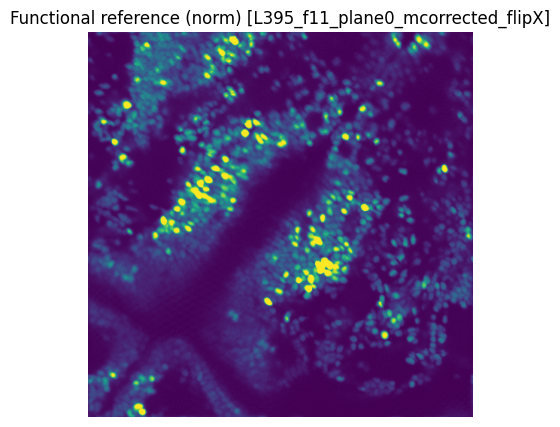

[INFO] Using existing refs for /Volumes/jlarsch/default/D2c/07_Data/Danin/L395_f11/03_analysis/functional/L395_f11_plane1_mcorrected_flipX.tif


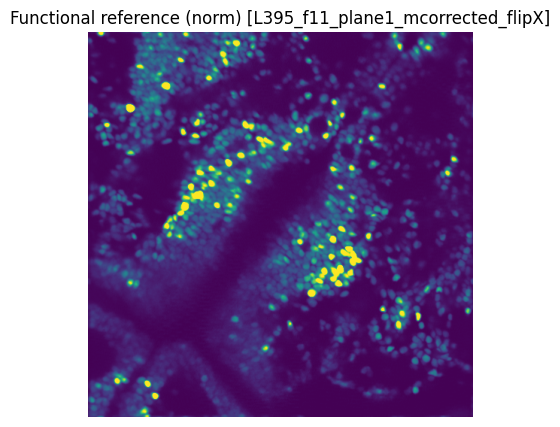

[INFO] Using existing refs for /Volumes/jlarsch/default/D2c/07_Data/Danin/L395_f11/03_analysis/functional/L395_f11_plane2_mcorrected_flipX.tif


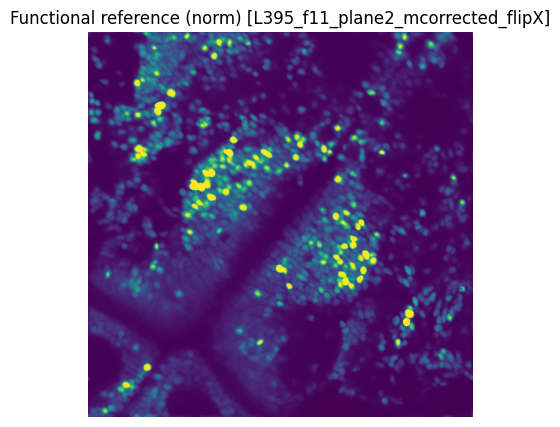

[INFO] Using existing refs for /Volumes/jlarsch/default/D2c/07_Data/Danin/L395_f11/03_analysis/functional/L395_f11_plane3_mcorrected_flipX.tif


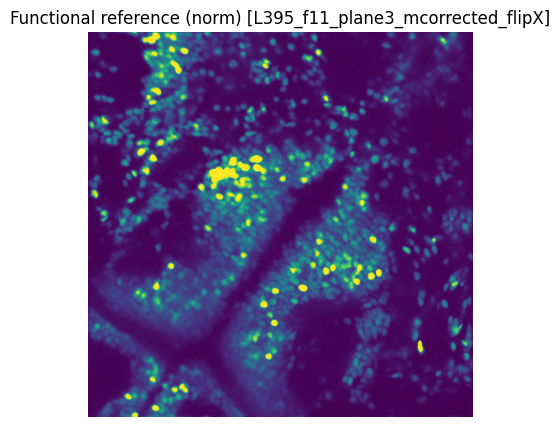

[INFO] Using existing refs for /Volumes/jlarsch/default/D2c/07_Data/Danin/L395_f11/03_analysis/functional/L395_f11_plane4_mcorrected_flipX.tif


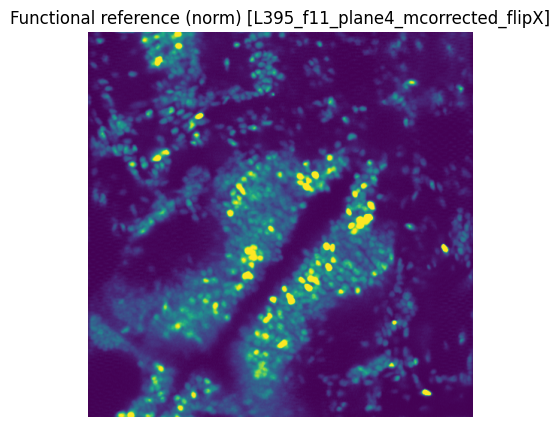

In [81]:
# [13]
# Load flipped functional data and build/reuse references
plane_refs = []
if not FLIPPED_LIST:
    raise FileNotFoundError("No flipped functional stacks available")
for fp in FLIPPED_LIST:
    fp = Path(fp)
    if not fp.exists():
        raise FileNotFoundError(f"Flipped functional stack not found: {fp}")
    vox_f = VOX_FUNC_BY_PATH.get(str(fp), {}) if "VOX_FUNC_BY_PATH" in globals() else {}
    stem = fp.stem
    raw_path = OUTDIR / (stem + "_ref_raw.tif")
    norm_path = OUTDIR / (stem + "_ref_norm.tif")
    plane_raws = sorted(OUTDIR.glob(stem + "_plane*_raw.tif"))
    if not REUSE_SAVED_REFS:
        plane_raws = []
    use_cached = REUSE_SAVED_REFS
    if use_cached and plane_raws:
        for rawp in plane_raws:
            match = re.search(r"plane(\d+)", rawp.stem)
            zi = int(match.group(1)) if match else None
            normp = OUTDIR / (stem + f"_plane{zi}_norm.tif")
            if not normp.exists():
                continue
            ref2d_raw_i = imread(rawp).astype(np.float32)
            ref2d_i = norm01(imread(normp))
            plane_refs.append({"label": f"{stem}_plane{zi}", "ref2d_raw": ref2d_raw_i, "ref2d": ref2d_i, "index": zi, "vox_func": vox_f})
            quickshow(ref2d_i, f"Functional reference (norm) [{stem} plane {zi}]")
        if plane_refs:
            continue
    if use_cached and raw_path.exists() and norm_path.exists():
        ref2d_raw = imread(raw_path).astype(np.float32)
        ref2d = norm01(imread(norm_path))
        plane_refs.append({"label": stem, "ref2d_raw": ref2d_raw, "ref2d": ref2d, "vox_func": vox_f})
        print(f"[INFO] Using existing refs for {fp}")
        quickshow(ref2d, f"Functional reference (norm) [{stem}]")
        continue
    func = imread(fp)
    print("Functional shape:", func.shape, "from", fp, "vox", vox_f)
    if func.ndim == 3:
        ref2d_raw = func.mean(axis=0).astype(np.float32)
        imwrite(raw_path, ref2d_raw.astype(np.float32))
        ref2d = norm01(ref2d_raw)
        imwrite(norm_path, (ref2d*65535).astype(np.uint16))
        plane_refs.append({"label": stem, "ref2d_raw": ref2d_raw, "ref2d": ref2d, "vox_func": vox_f})
        quickshow(ref2d, f"Functional reference (norm) [{stem}]")
    else:
        T, Z, H, W = func.shape
        for zi in range(Z):
            plane_t = func[:, zi, :, :]
            ref2d_raw_i = plane_t.mean(axis=0).astype(np.float32)
            rawp = OUTDIR / (stem + f"_plane{zi}_raw.tif")
            normp = OUTDIR / (stem + f"_plane{zi}_norm.tif")
            imwrite(rawp, ref2d_raw_i.astype(np.float32))
            ref2d_i = norm01(ref2d_raw_i)
            imwrite(normp, (ref2d_i*65535).astype(np.uint16))
            plane_refs.append({"label": f"{stem}_plane{zi}", "ref2d_raw": ref2d_raw_i, "ref2d": ref2d_i, "index": zi, "vox_func": vox_f})
            quickshow(ref2d_i, f"Functional reference (norm) [{stem} plane {zi}]")

if not plane_refs:
    raise RuntimeError("No functional planes available")
ref2d_raw = plane_refs[0]["ref2d_raw"]
ref2d = plane_refs[0]["ref2d"]

### [7] Convert anatomy NRRD to TIFF (reorder to Z,X,Y) and use it
Convert anatomy NRRD to TIFF with proper axis order for downstream steps.

In [82]:
# [15]
# 1.5) Convert anatomy NRRD to TIFF (reorder to Z,X,Y) and use it
if ANAT_STACK_PATH.suffix.lower() == '.nrrd':
    nrrd_path = ANAT_STACK_PATH
    converted_anat_tif = OUTDIR / (ANAT_STACK_PATH.stem + '_converted.tif')
    if converted_anat_tif.exists():
        data = imread(converted_anat_tif)
        print(f"[INFO] Using existing converted anatomy: {converted_anat_tif}")
    else:
        try:
            import nrrd
            data, _ = nrrd.read(str(nrrd_path))
        except Exception:
            try:
                import SimpleITK as sitk
                data = sitk.GetArrayFromImage(sitk.ReadImage(str(nrrd_path)))
            except Exception as e:
                raise e
        print('NRRD anatomy shape (as read):', data.shape)
        if data.ndim == 3 and data.shape[-1] < min(data.shape[0], data.shape[1]):
            data = data.transpose(2, 1, 0)
            print('Reordered anatomy to (Z, X, Y):', data.shape)
        imwrite(converted_anat_tif, data.astype(data.dtype))
        print(f"[INFO] Converted anatomy saved to {converted_anat_tif}")
    ANAT_STACK_PATH = converted_anat_tif
else:
    print('[INFO] Anatomy already TIFF; no conversion')

[INFO] Using existing converted anatomy: /Volumes/jlarsch/default/D2c/07_Data/Danin/L395_f11/03_analysis/functional/L395_f11_anatomy_2P_GCaMP_converted.tif


### [8] Find the best matching Z in the 2P anatomy stack
Compute NCC across planes to find the best matching Z slice.

In [83]:
# [17]
anat = imread(ANAT_STACK_PATH)
print("Anatomy shape:", anat.shape)

# Optional pre-filter to enhance structure
anat_f = np.stack([local_unsharp(norm01(s), 1.0, 0.6) for s in anat], axis=0)

FORCE_REF_RESIZE = globals().get('FORCE_REF_RESIZE', False)

for pr in plane_refs:
    ref_match = local_unsharp(norm01(pr['ref2d_raw']), 1.0, 0.6)
    # Optional: rescale functional reference to match anatomy XY before NCC (legacy-style)
    if RESCALE_FOR_NCC:
        try:
            if 'VOX_FUNC' in globals() and 'VOX_ANAT' in globals() and VOX_FUNC and VOX_ANAT:
                _sy = float(VOX_FUNC.get('Y', 1.0)) / float(VOX_ANAT.get('Y', 1.0))
                _sx = float(VOX_FUNC.get('X', 1.0)) / float(VOX_ANAT.get('X', 1.0))
                print(f"Rescale for NCC [{pr['label']}]: sy={_sy:.4f}, sx={_sx:.4f}, ref shape {ref_match.shape}")
                ref_match = rescale_to_match_xy(ref_match, VOX_FUNC, VOX_ANAT)
                print(f"→ Rescaled ref shape {ref_match.shape}")
        except Exception as _e:
            print('Warning: voxel-based rescale skipped:', _e)
    if ref_match.shape != anat_f[0].shape:
        if FORCE_REF_RESIZE:
            print(f"[WARN] Ref/anat shape mismatch for {pr['label']}: {ref_match.shape} vs {anat_f[0].shape}; resizing ref")
            ref_match = transform.resize(ref_match, anat_f[0].shape, order=1, mode='reflect', preserve_range=True, anti_aliasing=True).astype(np.float32)
        else:
            print(f"[INFO] Using ref shape {ref_match.shape} vs anat {anat_f[0].shape}; matcher will slide template")
    best_z, scores = best_z_by_ncc(ref_match, anat_f, use_cv2=True)
    pr['ref_match'] = ref_match
    pr['ncc_scores'] = scores
    pr['best_z'] = best_z
    print(f"[{pr['label']}] Best Z in anatomy: {best_z}")
    pd.Series(scores).to_csv(OUTDIR / (f"bestZ_scores_{pr['label']}.csv"), index=False)

# Use first plane for downstream convenience
best_z = plane_refs[0]['best_z']
ref_match = plane_refs[0]['ref_match']

Anatomy shape: (216, 750, 750)
[INFO] Using ref shape (512, 512) vs anat (750, 750); matcher will slide template
[L395_f11_plane0_mcorrected_flipX] Best Z in anatomy: 124
[INFO] Using ref shape (512, 512) vs anat (750, 750); matcher will slide template
[L395_f11_plane1_mcorrected_flipX] Best Z in anatomy: 123
[INFO] Using ref shape (512, 512) vs anat (750, 750); matcher will slide template
[L395_f11_plane2_mcorrected_flipX] Best Z in anatomy: 118
[INFO] Using ref shape (512, 512) vs anat (750, 750); matcher will slide template
[L395_f11_plane3_mcorrected_flipX] Best Z in anatomy: 113
[INFO] Using ref shape (512, 512) vs anat (750, 750); matcher will slide template
[L395_f11_plane4_mcorrected_flipX] Best Z in anatomy: 107


### [9] Plot NCC score curves for all planes
Visualize NCC scores versus Z to inspect the chosen plane.

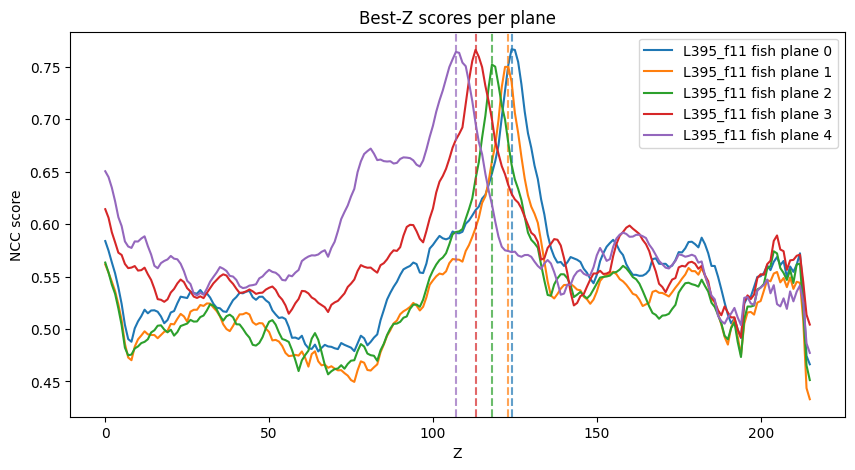

In [84]:
# [19]
# Plot NCC score curves for all planes
if plane_refs:
    import matplotlib.pyplot as _plt
    _plt.figure(figsize=(10,5))
    for pr in plane_refs:
        scores = pr.get("ncc_scores", None)
        if scores is None:
            continue
        m = re.search(r"plane(\d+)", pr.get("label",""))
        plane_no = m.group(1) if m else "?"
        lbl = f"{FISH_ID} fish plane {plane_no}"
        line, = _plt.plot(scores, label=lbl)
        if "best_z" in pr:
            _plt.axvline(pr["best_z"], color=line.get_color(), linestyle="--", alpha=0.7)
    _plt.xlabel("Z")
    _plt.ylabel("NCC score")
    _plt.title("Best-Z scores per plane")
    _plt.legend()
    _plt.show()
else:
    print("No plane_refs available for NCC plot")

### [10] Estimate in-plane transform (functional → anatomy[best‑Z])
Estimate 2D transform from functional reference to the selected anatomy plane.

In [85]:
# [21]
tforms = []
for pr in plane_refs:
    bz = pr['best_z']
    a_slice = anat_f[bz]
    ref_match = pr['ref_match']
    if ref_match.shape != a_slice.shape:
        print(f"[WARN] Ref/anat shape mismatch for transform {pr['label']}: {ref_match.shape} vs {a_slice.shape}")
    # Stage 1: Similarity (rigid+scale) via ORB+RANSAC
    tform_sim = estimate_inplane_transform(ref_match, a_slice, method='similarity')
    print(f"[{pr['label']}] Similarity tform:", tform_sim.params)

    # Stage 2: Affine via ORB+RANSAC
    tform_aff = estimate_inplane_transform(ref_match, a_slice, method='affine')
    print(f"[{pr['label']}] Affine (RANSAC) tform:", tform_aff.params)

    # Stage 3: Refine affine with ECC
    tform = refine_affine_ecc(ref_match, a_slice, init_tform=tform_aff, max_iters=300, eps=1e-6, pyr_levels=3)
    print(f"[{pr['label']}] Affine (ECC refined) tform:", tform.params)

    pr['tform'] = tform
    tforms.append(tform)
    
    # Warp the matched (normalized) reference into anatomy space for visual QA
    ref_warped_raw = apply_transform_2d(pr['ref_match'], tform, output_shape=a_slice.shape, order=1)
    pr['ref_warped_raw'] = ref_warped_raw

# Persist per-plane transforms so QA cells can reuse without recomputing
try:
    tform_records = []
    for idx, pr in enumerate(plane_refs):
        tf = pr.get('tform', None)
        if tf is None:
            continue
        params = tf.params
        tform_records.append({
            'plane_index': idx,
            'label': pr.get('label', f'plane{idx}'),
            'best_z': int(pr.get('best_z', best_z if 'best_z' in globals() else 0)),
            'm00': float(params[0,0]), 'm01': float(params[0,1]), 'm02': float(params[0,2]),
            'm10': float(params[1,0]), 'm11': float(params[1,1]), 'm12': float(params[1,2]),
        })
    if tform_records:
        pd.DataFrame(tform_records).to_csv(OUTDIR/'tforms_by_plane.csv', index=False)
except Exception as _e:
    print('Could not save per-plane transforms:', _e)


# Keep first-plane artifacts for downstream convenience (keep ref/tform in sync)
FIRST_PLANE_LABEL = plane_refs[0].get('label', 'plane0')
tform = plane_refs[0]['tform']
ref_match = plane_refs[0].get('ref_match', plane_refs[0].get('ref2d_raw', plane_refs[0].get('ref2d')))
ref_warped_raw = plane_refs[0]['ref_warped_raw']
ref2d_raw = plane_refs[0].get('ref2d_raw', ref2d_raw)
ref2d = plane_refs[0].get('ref2d', ref2d)

[WARN] Ref/anat shape mismatch for transform L395_f11_plane0_mcorrected_flipX: (512, 512) vs (750, 750)
[L395_f11_plane0_mcorrected_flipX] Similarity tform: [[ 1.04065207e+00 -5.99469211e-03  1.23094780e+02]
 [ 5.99469211e-03  1.04065207e+00  1.27709975e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[L395_f11_plane0_mcorrected_flipX] Affine (RANSAC) tform: [[1.02779649e+00 4.50179778e-03 1.24390137e+02]
 [2.76263135e-03 1.04741273e+00 1.27079811e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[L395_f11_plane0_mcorrected_flipX] Affine (ECC refined) tform: [[1.0250182e+00 5.8436547e-03 1.2505934e+02]
 [4.3443963e-03 1.0444790e+00 1.2758070e+02]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]
[WARN] Ref/anat shape mismatch for transform L395_f11_plane1_mcorrected_flipX: (512, 512) vs (750, 750)
[L395_f11_plane1_mcorrected_flipX] Similarity tform: [[ 1.03547932e+00 -2.79025434e-03  1.19907201e+02]
 [ 2.79025434e-03  1.03547932e+00  1.23902468e+02]
 [ 0.00000000e+00  0.0000000

### [11] Interactive overlay: toggle channels like FIJI
Interactive viewer to overlay functional and anatomy images.

In [86]:
# [23]

# Interactive overlay: toggle channels like FIJI
try:
    import ipywidgets as widgets
    from IPython.display import display
    _HAS_WIDGETS = True
except Exception as _e:
    _HAS_WIDGETS = False
    print('ipywidgets not available; skipping interactive overlay. Install ipywidgets to enable.')

# Prepare normalized views (may depend on earlier cells)
__overlay_ready = True
try:
    if not plane_refs:
        raise RuntimeError('No plane_refs available')
except Exception:
    print('Interactive overlay prerequisites missing (ref2d/anat/best_z). Run previous cells first.)')
    __overlay_ready = False

# Helpers
_COLORS = {
    'green':   (0.0, 1.0, 0.0),
    'magenta': (1.0, 0.0, 1.0),
    'red':     (1.0, 0.0, 0.0),
    'blue':    (0.0, 0.0, 1.0),
    'cyan':    (0.0, 1.0, 1.0),
    'yellow':  (1.0, 1.0, 0.0),
    'white':   (1.0, 1.0, 1.0)
}

def _apply_color(gray01, rgb):
    r, g, b = rgb
    return np.stack([gray01*r, gray01*g, gray01*b], axis=-1)

def _first_available(*vals):
    for v in vals:
        if v is not None:
            return v
    return None

def _get_views(p_idx=0):
    p_idx = int(max(0, min(len(plane_refs)-1, p_idx)))
    pr = plane_refs[p_idx]
    label = pr.get('label','?')
    bz = int(pr.get('best_z', best_z if 'best_z' in globals() else 0))
    mov_src = _first_available(pr.get('ref_match'), pr.get('ref2d_raw'), pr.get('ref2d'))
    f_src = mov_src
    src_label = 'raw'
    if pr.get('tform') is not None and mov_src is not None:
        try:
            f_src = apply_transform_2d(mov_src, pr['tform'], output_shape=anat[bz].shape, order=1)
            src_label = 'tform-warp'
        except Exception:
            f_src = mov_src
            src_label = 'raw'
    f_vis = norm01(f_src)
    a_vis = norm01(anat_f[bz]) if 'anat_f' in globals() else norm01(anat[bz])
    if f_vis.shape != a_vis.shape:
        f_vis = transform.resize(f_vis, a_vis.shape, order=1, mode='reflect', preserve_range=True, anti_aliasing=True).astype(np.float32)
    return f_vis, a_vis, label, src_label

# Widgets
plane_idx_sl = widgets.IntSlider(value=0, min=0, max=max(0, len(plane_refs)-1), step=1, description='Plane', readout=True)
show_func_cb = widgets.Checkbox(value=True, description='Show functional')
show_anat_cb = widgets.Checkbox(value=True, description='Show anatomy')
func_color_dd = widgets.Dropdown(options=list(_COLORS.keys()), value='green', description='Func LUT')
anat_color_dd = widgets.Dropdown(options=list(_COLORS.keys()), value='magenta', description='Anat LUT')
func_alpha_sl = widgets.FloatSlider(value=1.0, min=0.0, max=1.0, step=0.05, readout_format='.2f', description='Func α')
anat_alpha_sl = widgets.FloatSlider(value=1.0, min=0.0, max=1.0, step=0.05, readout_format='.2f', description='Anat α')


def _render(p_idx=0, show_func=True, show_anat=True, func_color='green', anat_color='magenta', func_alpha=1.0, anat_alpha=1.0):
    f_vis, a_vis, lbl, src_label = _get_views(p_idx)
    out = np.zeros((f_vis.shape[0], f_vis.shape[1], 3), dtype=np.float32)
    if show_anat:
        out += _apply_color(a_vis, _COLORS[anat_color]) * float(anat_alpha)
    if show_func:
        out += _apply_color(f_vis, _COLORS[func_color]) * float(func_alpha)
    out = np.clip(out, 0, 1)
    plt.figure(figsize=(10,10))
    plt.imshow(out)
    plt.title(f'Overlay — plane={lbl} | func[{func_color}] alpha={func_alpha:.2f}, anat[{anat_color}] alpha={anat_alpha:.2f} | func src: {src_label}')
    plt.axis('off')
    plt.show()

if _HAS_WIDGETS and __overlay_ready:
    ui = widgets.VBox([
        plane_idx_sl,
        widgets.HBox([show_func_cb, func_color_dd, func_alpha_sl]),
        widgets.HBox([show_anat_cb, anat_color_dd, anat_alpha_sl])
    ])
    out = widgets.interactive_output(_render, {
        'p_idx': plane_idx_sl,
        'show_func': show_func_cb,
        'show_anat': show_anat_cb,
        'func_color': func_color_dd,
        'anat_color': anat_color_dd,
        'func_alpha': func_alpha_sl,
        'anat_alpha': anat_alpha_sl,
    })
    display(ui, out)
elif _HAS_WIDGETS and not __overlay_ready:
    print('Interactive overlay not shown: run best-Z cell first.')

Output()

### [12] Cellpose segmentation on functional reference (8-bit input)
Run Cellpose segmentation on the functional reference image.

In [87]:
# [25]

# Cellpose segmentation on functional reference (8-bit input)
# Segments all functional planes unless skipped.
CP_SAVE_PNG = False
CP_SAVE_TIF = True
CP_SKIP_IF_EXISTS = True
CP_PLANE_INDICES = None  # set to list of indices to subset, or None for all

from cellpose import models, io
io.logger_setup()
MODEL_PATH = '/Volumes/jlarsch/default/D2c/07_Data/Danin/Cellpose/models/2pf_cpsam_20250915_115140'
model = models.CellposeModel(gpu=True, pretrained_model=MODEL_PATH)

if not plane_refs:
    raise RuntimeError('No functional planes available for Cellpose')

plane_indices = CP_PLANE_INDICES if CP_PLANE_INDICES is not None else range(len(plane_refs))
for pi in plane_indices:
    pi_int = int(pi)
    if pi_int < 0 or pi_int >= len(plane_refs):
        print(f"[SKIP] plane index {pi_int} out of range")
        continue
    pr = plane_refs[pi_int]
    label = pr.get('label', f'plane{pi_int}')
    mask_path = OUTDIR / f"{label}_cellpose_masks.tif"
    if CP_SKIP_IF_EXISTS and mask_path.exists():
        print(f"[SKIP] existing masks: {mask_path}")
        continue
    ref_for_cp = pr.get('ref2d_raw') if pr.get('ref2d_raw') is not None else pr.get('ref_match') or pr.get('ref2d')
    if ref_for_cp is None:
        print(f"[SKIP] no reference image for {label}")
        continue
    cp_img = (norm01(ref_for_cp) * 255).astype(np.uint8)
    cp_input_path = OUTDIR / f"{label}_cellpose_input.tif"
    imwrite(cp_input_path, cp_img)
    result = model.eval([cp_img], channels=[0,0], channel_axis=None, normalize=True)
    try:
        masks, flows, styles, diams = result
    except ValueError:
        masks, flows, styles = result
        diams = None
    mask_arr = masks[0].astype(np.uint16)
    if CP_SAVE_TIF:
        imwrite(mask_path, mask_arr)
    if CP_SAVE_PNG:
        try:
            from PIL import Image
            Image.fromarray(mask_arr.astype('uint16')).save(mask_path.with_suffix('.png'))
        except Exception as e:
            print('[WARN] PNG save failed:', e)
    print(f"[CP] {label}: input={cp_input_path}, masks={mask_path}")

2025-11-28 13:05:28,123 [INFO] WRITING LOG OUTPUT TO /Users/ddharmap/.cellpose/run.log
2025-11-28 13:05:28,124 [INFO] 
cellpose version: 	4.0.7 
platform:       	darwin 
python version: 	3.11.11 
torch version:  	2.9.0
2025-11-28 13:05:28,439 [INFO] ** TORCH MPS version installed and working. **
2025-11-28 13:05:28,440 [INFO] >>>> using GPU (MPS)
2025-11-28 13:05:29,599 [INFO] >>>> loading model /Volumes/jlarsch/default/D2c/07_Data/Danin/Cellpose/models/2pf_cpsam_20250915_115140
[SKIP] existing masks: /Volumes/jlarsch/default/D2c/07_Data/Danin/L395_f11/03_analysis/functional/L395_f11_plane0_mcorrected_flipX_cellpose_masks.tif
[SKIP] existing masks: /Volumes/jlarsch/default/D2c/07_Data/Danin/L395_f11/03_analysis/functional/L395_f11_plane1_mcorrected_flipX_cellpose_masks.tif
[SKIP] existing masks: /Volumes/jlarsch/default/D2c/07_Data/Danin/L395_f11/03_analysis/functional/L395_f11_plane2_mcorrected_flipX_cellpose_masks.tif
[SKIP] existing masks: /Volumes/jlarsch/default/D2c/07_Data/Danin/

### [12b] Functional labels on references
Plot functional label masks over each functional reference to verify the mapping before downstream QC.


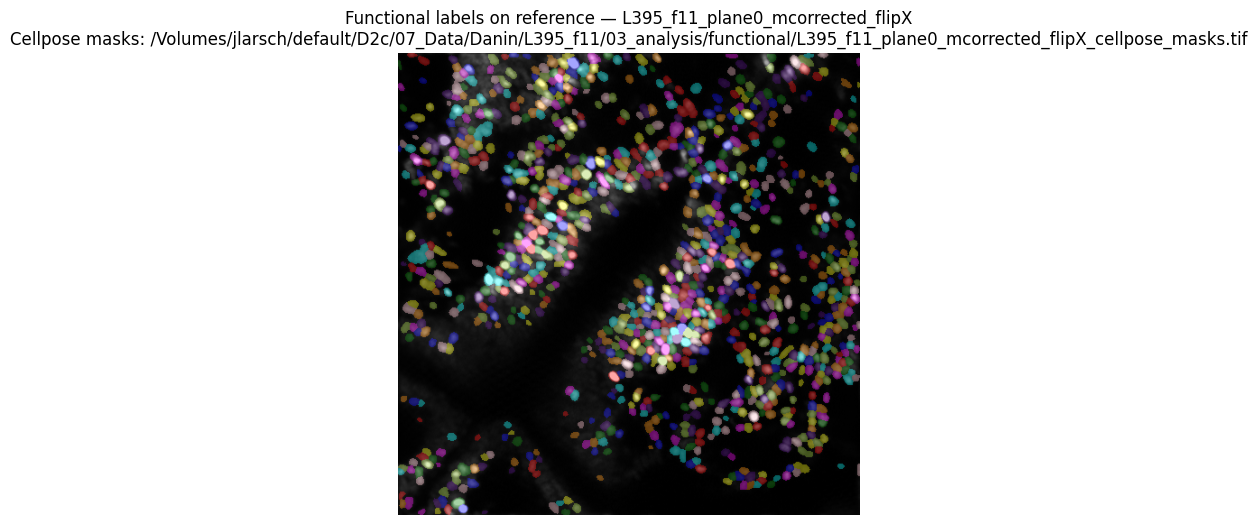

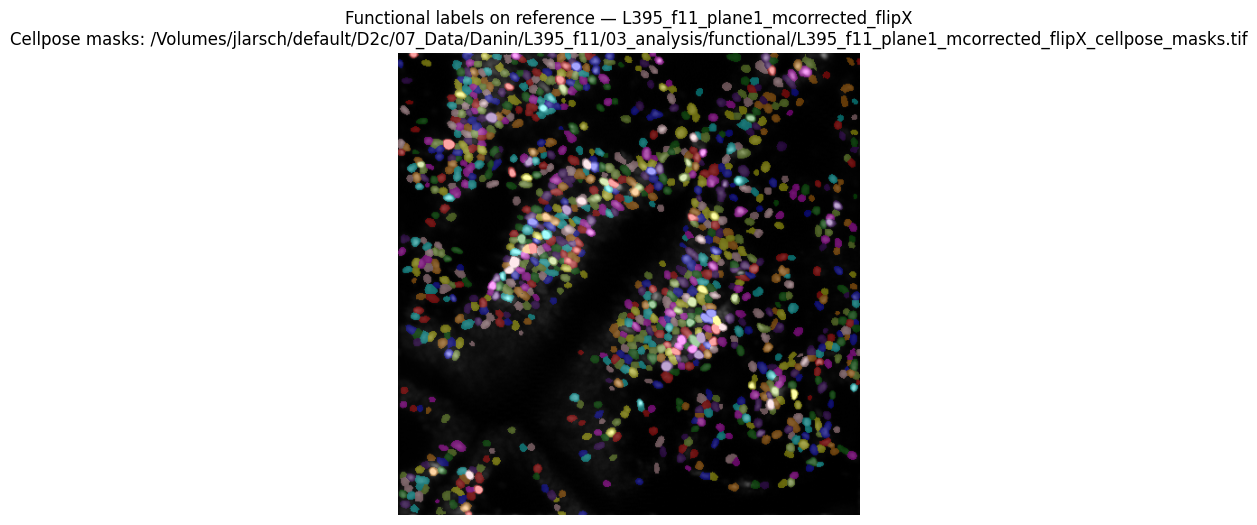

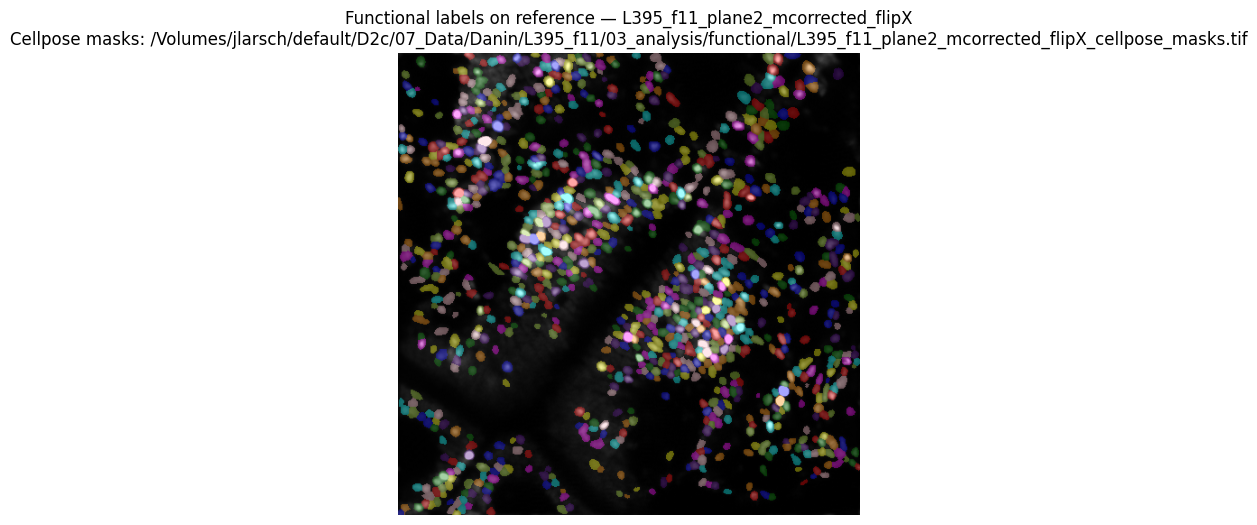

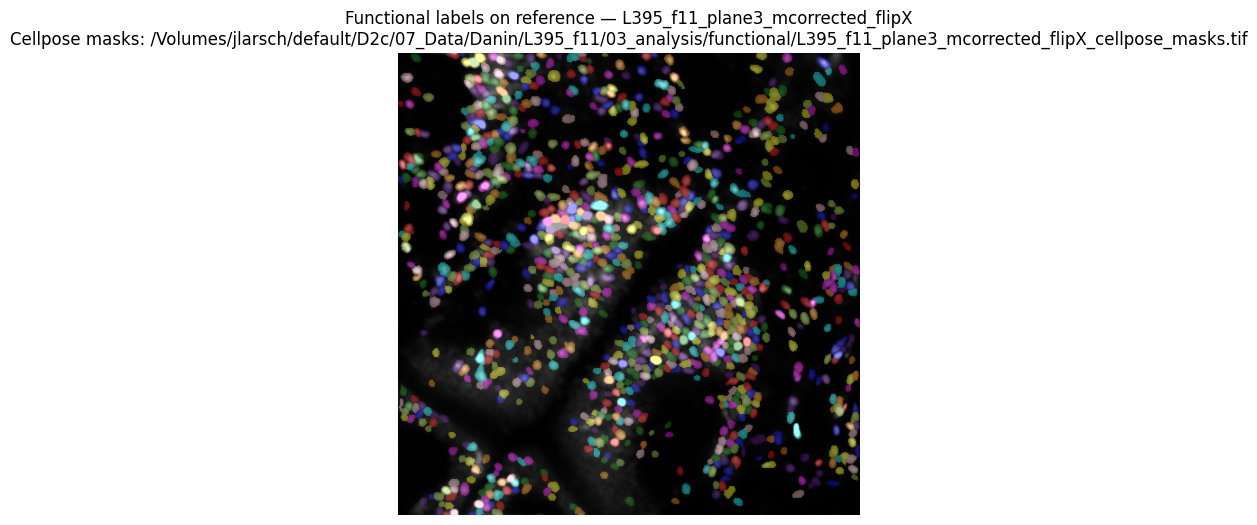

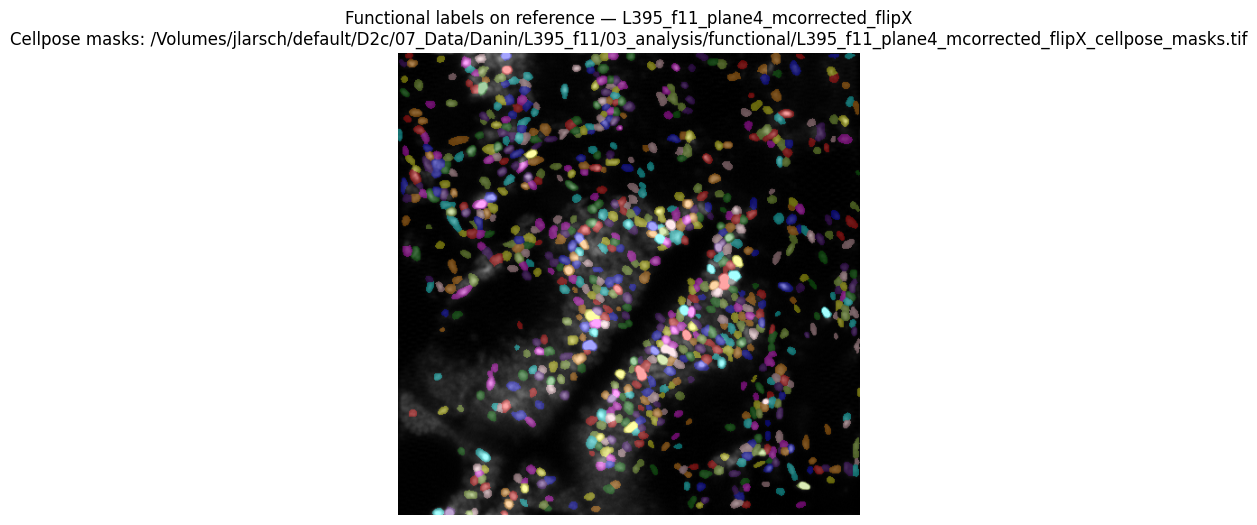

In [88]:
# [12b]
# Plot functional labels on top of each functional reference (per-plane)
from skimage import color as _color

def _get_labels_for_plane(pr, p_idx):
    lbl = pr.get('label', f'plane{p_idx}')
    cp_path = OUTDIR / f"{lbl}_cellpose_masks.tif"
    if cp_path.exists():
        arr = _ensure_uint_labels(imread(cp_path))
        if arr.ndim == 3 and arr.shape[-1] in (3, 4):
            arr = arr[..., 0]
        if arr.ndim == 3 and arr.shape[0] == 1:
            arr = arr[0]
        return arr, f"Cellpose masks: {cp_path}"
    fl = globals().get('func_labels', None)
    if fl is not None:
        arr = fl
        if isinstance(arr, list):
            if p_idx < len(arr):
                arr_i = _ensure_uint_labels(arr[p_idx])
                return arr_i, f"func_labels list[{p_idx}]"
        else:
            arr_np = _ensure_uint_labels(np.asarray(arr))
            if arr_np.ndim == 3:
                src_idx = pr.get('index', p_idx)
                if src_idx < arr_np.shape[0]:
                    return arr_np[src_idx], f"func_labels stack[{src_idx}]"
            elif arr_np.ndim == 2:
                return arr_np, "func_labels (2D)"
    if FUNC_LABELS_PATH and os.path.exists(FUNC_LABELS_PATH):
        arr = _ensure_uint_labels(imread(FUNC_LABELS_PATH))
        if arr.ndim == 3:
            src_idx = pr.get('index', p_idx)
            if src_idx < arr.shape[0]:
                return arr[src_idx], f"FUNC_LABELS_PATH[{src_idx}]: {Path(FUNC_LABELS_PATH).name}"
        elif arr.ndim == 2:
            return arr, f"FUNC_LABELS_PATH: {Path(FUNC_LABELS_PATH).name}"
    return None, None

if 'plane_refs' not in globals() or not plane_refs:
    print('No functional references to plot.')
else:
    import matplotlib.pyplot as _plt
    for p_idx, pr in enumerate(plane_refs):
        lbl = pr.get('label', f'plane{p_idx}')
        labels, src_desc = _get_labels_for_plane(pr, p_idx)
        if labels is None:
            print(f"[SKIP] No labels found for {lbl}")
            continue
        if labels.ndim == 3 and labels.shape[-1] in (3, 4):
            labels = labels[..., 0]
        if labels.ndim != 2:
            print(f"[SKIP] Labels for {lbl} have unsupported shape {labels.shape}")
            continue
        ref_img = pr.get('ref2d_raw', None)
        if ref_img is None:
            ref_img = pr.get('ref2d', None)
        if ref_img is None:
            print(f"[SKIP] No functional reference for {lbl}")
            continue
        if ref_img.ndim == 3 and ref_img.shape[-1] in (3, 4):
            ref_img = ref_img[..., 0]
        if labels.shape != ref_img.shape:
            print(f"[SKIP] Label/ref shape mismatch for {lbl}: labels {labels.shape}, ref {ref_img.shape}")
            continue
        ref_vis = norm01(ref_img)
        overlay = _color.label2rgb(labels, image=ref_vis, bg_label=0, alpha=0.35, image_alpha=1.0)
        _plt.figure(figsize=(6, 6))
        _plt.imshow(overlay)
        title_src = src_desc if src_desc else 'labels'
        _plt.title(f"Functional labels on reference — {lbl}\n{title_src}")
        _plt.axis('off')
        _plt.show()


### [13] Mask diameters by axis (µm)
Measure per-axis diameters of segmentation masks in microns.

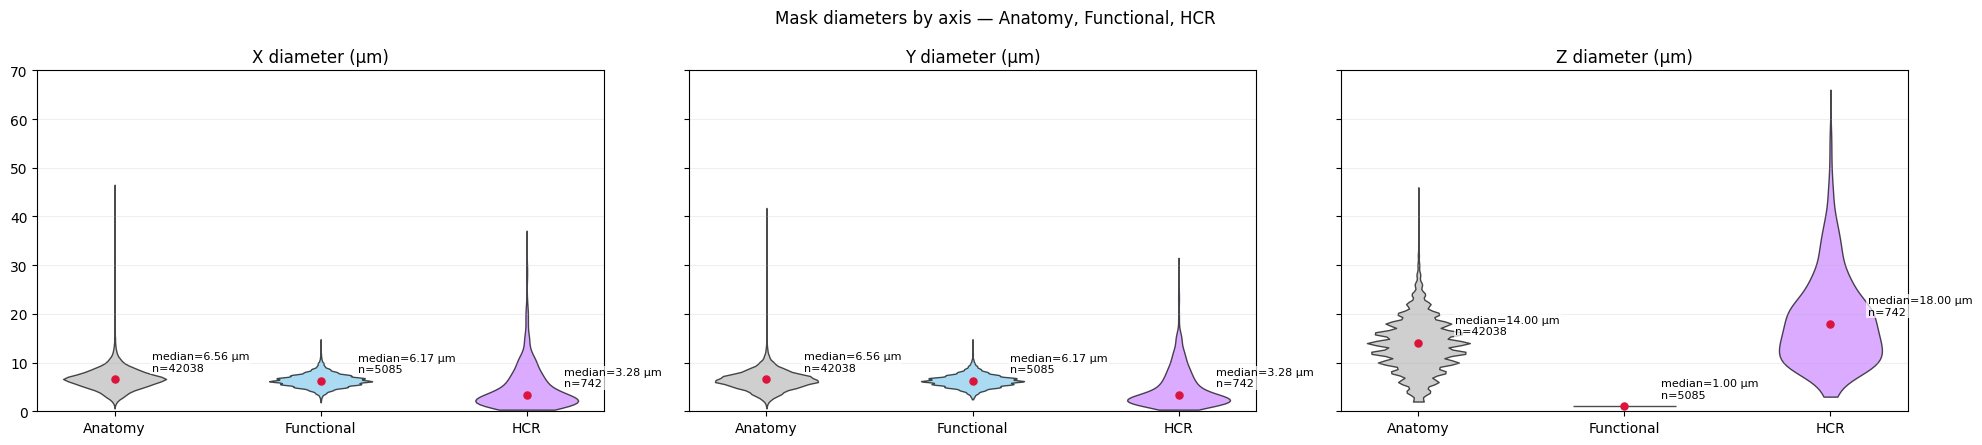

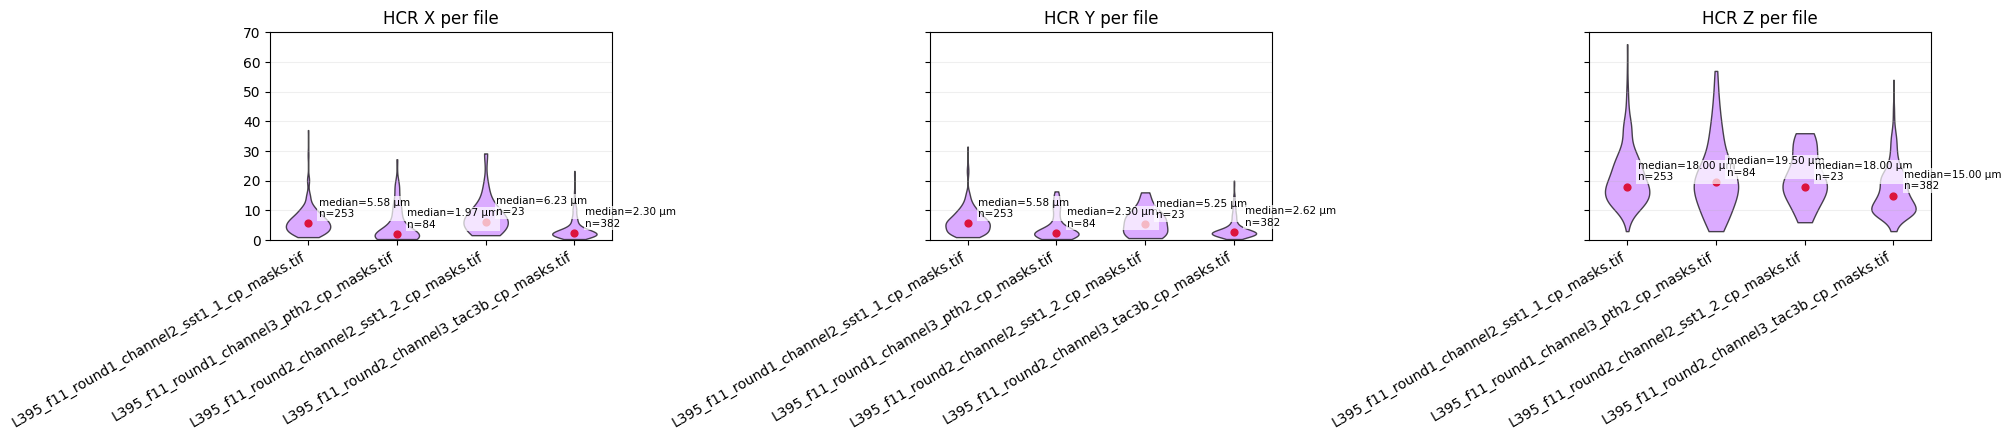

Outlier diameters (IQR fence, pooled), sorted high→low (per-plane/per-file labels):


dataset  x_median  y_median  z_median      n
0     Anatomy  6.560427  6.560427      14.0  42038
1  Functional  6.166852  6.166852       1.0   5085
2         HCR  3.279636  3.279636      18.0    742

In [89]:
# [27]

# Mask diameters (µm) for anatomy, functional, HCR (if available)
import numpy as _np, matplotlib.pyplot as _plt

def _load_labels_or_none(path):
    if path is None:
        return None
    try:
        if not os.path.exists(path):
            return None
        arr = _ensure_uint_labels(imread(path))
        if arr.ndim == 3 and arr.shape[-1] in (3,4):
            arr = arr[...,0]
        return arr
    except Exception as _e:
        print('Could not load labels from', path, ':', _e)
        return None

dfs = []
anat_labels = _load_labels_or_none(ANAT_LABELS_PATH)
if anat_labels is not None:
    anat_3d = anat_labels if anat_labels.ndim == 3 else anat_labels[None, ...]
    vox_a = {
        'Z': float(VOX_ANAT.get('Z',1.0)) if 'VOX_ANAT' in globals() and VOX_ANAT else 1.0,
        'Y': float(VOX_ANAT.get('Y',1.0)) if 'VOX_ANAT' in globals() and VOX_ANAT else 1.0,
        'X': float(VOX_ANAT.get('X',1.0)) if 'VOX_ANAT' in globals() and VOX_ANAT else 1.0,
    }
    df_anat_diam = diameters_um_from_array(anat_3d, vox_a)
    df_anat_diam['dataset'] = 'Anatomy'
    dfs.append(df_anat_diam)

# Optional: 2P anatomy masks (Cellpose) fallback: if ANAT_LABELS_PATH missing, try structural/cp_masks
if anat_labels is None:
    anat2p_path = Path('/Volumes/jlarsch/default/D2c/07_Data/Danin/L395_f11/03_analysis/structural/cp_masks/L395_f11_anatomy_00001_8bit_cp_masks.tif')
    anat2p_labels = _load_labels_or_none(anat2p_path)
    if anat2p_labels is not None:
        anat2p_3d = anat2p_labels if anat2p_labels.ndim == 3 else anat2p_labels[None, ...]
        vox_a2p = {
            'Z': float(VOX_ANAT.get('Z',1.0)) if 'VOX_ANAT' in globals() and VOX_ANAT else 1.0,
            'Y': float(VOX_ANAT.get('Y',1.0)) if 'VOX_ANAT' in globals() and VOX_ANAT else 1.0,
            'X': float(VOX_ANAT.get('X',1.0)) if 'VOX_ANAT' in globals() and VOX_ANAT else 1.0,
        }
        df_anat2p_diam = diameters_um_from_array(anat2p_3d, vox_a2p)
        df_anat2p_diam['dataset'] = 'Anatomy2P'
        dfs.append(df_anat2p_diam)


func_labels = None
_cp_masks = []
try:
    for pr in plane_refs:
        lbl = pr.get('label', None)
        if lbl is None:
            continue
        mp = OUTDIR / f"{lbl}_cellpose_masks.tif"
        if not mp.exists():
            continue
        m = imread(mp)
        m = _np.asarray(m)
        if m.ndim == 3 and m.shape[-1] in (3,4):
            m = m[...,0]
        m = _ensure_uint_labels(m)
        _cp_masks.append(m)
    if _cp_masks:
        func_labels = _cp_masks  # list of per-plane masks with unique labels
except Exception as _e:
    print('Warning: loading cellpose masks failed:', _e)
if func_labels is None:
    func_labels = _load_labels_or_none(FUNC_LABELS_PATH)
if func_labels is not None:
    vox_f = {
        'Z': 1.0,
        'Y': float(VOX_FUNC.get('Y',1.0)) if 'VOX_FUNC' in globals() and VOX_FUNC else 1.0,
        'X': float(VOX_FUNC.get('X',1.0)) if 'VOX_FUNC' in globals() and VOX_FUNC else 1.0,
    }
    func_dfs = []
    if isinstance(func_labels, list):
        for i, m in enumerate(func_labels):
            func_3d = m if m.ndim == 3 else m[None, ...]
            df_i = diameters_um_from_array(func_3d, vox_f)
            df_i['plane_idx'] = i
            func_dfs.append(df_i)
        df_func_diam = pd.concat(func_dfs, ignore_index=True) if func_dfs else None
    else:
        func_3d = func_labels if func_labels.ndim == 3 else func_labels[None, ...]
        df_func_diam = diameters_um_from_array(func_3d, vox_f)
    if df_func_diam is not None:
        df_func_diam['dataset'] = 'Functional'
        dfs.append(df_func_diam)

HCR_LABELS_PATHS = globals().get('HCR_LABELS_PATHS', []) if 'HCR_LABELS_PATHS' in globals() else []
if (not HCR_LABELS_PATHS) and 'HCR_LABELS_PATH' in globals() and HCR_LABELS_PATH:
    HCR_LABELS_PATHS = [HCR_LABELS_PATH]

hcr_dfs = []
for hp in HCR_LABELS_PATHS:
    hl = _load_labels_or_none(hp)
    if hl is None:
        continue
    hcr_3d = hl if hl.ndim == 3 else hl[None, ...]
    vox_h = {
        'Z': float(VOX_HCR.get('Z',1.0)) if 'VOX_HCR' in globals() and VOX_HCR else 1.0,
        'Y': float(VOX_HCR.get('Y',1.0)) if 'VOX_HCR' in globals() and VOX_HCR else 1.0,
        'X': float(VOX_HCR.get('X',1.0)) if 'VOX_HCR' in globals() and VOX_HCR else 1.0,
    }
    df_h = diameters_um_from_array(hcr_3d, vox_h)
    df_h['dataset'] = 'HCR'
    df_h['file'] = Path(hp).name
    hcr_dfs.append(df_h)
if hcr_dfs:
    dfs.append(pd.concat(hcr_dfs, ignore_index=True))

if not dfs:
    print('No label volumes available for diameter analysis.')
else:
    df_all = pd.concat(dfs, ignore_index=True)
    try:
        df_all.to_pickle(OUTDIR / 'diameters_df_all.pkl')
    except Exception:
        pass
    cats_plot = ['Anatomy','Functional','HCR']
    present = [c for c in cats_plot if c in df_all['dataset'].unique()]

    def _series_for_axis(axis_col):
        ser = []
        for ds in present:
            vals = df_all.loc[df_all['dataset']==ds, axis_col].to_numpy(dtype=float)
            ser.append(vals)
        return ser

    series_x = _series_for_axis('x_um')
    series_y = _series_for_axis('y_um')
    series_z = _series_for_axis('z_um')

    all_vals = _np.concatenate([a for a in (series_x + series_y + series_z) if a.size]) if any(
        (a.size for a in (series_x + series_y + series_z))) else _np.array([])
    y_max_data = float(_np.max(all_vals)) if all_vals.size else 10.0
    from math import ceil as _ceil
    y_max = max(10.0, 10.0 * _ceil(y_max_data / 10.0))
    yticks = _np.arange(0.0, y_max + 0.1, 10.0)

    color_map = {'Anatomy':'#bbbbbb', 'Functional':'#88ccee', 'HCR':'#cc88ff'}
    colors = [color_map.get(ds, '#cccccc') for ds in present]

    fig, axes = _plt.subplots(1, 3, figsize=(20, 4.5), sharey=True)
    if not hasattr(axes, '__len__'):
        axes = [axes]
    axis_cols = ['x_um', 'y_um', 'z_um']
    for ax, ser, title, axis_col in zip(axes, [series_x, series_y, series_z], ['X diameter (µm)', 'Y diameter (µm)', 'Z diameter (µm)'], axis_cols):
        if not any(a.size for a in ser):
            ax.set_visible(False)
            continue
        parts = ax.violinplot(ser, showmeans=False, showmedians=False, showextrema=False)
        for i, pc in enumerate(parts['bodies']):
            pc.set_facecolor(colors[i])
            pc.set_edgecolor('black')
            pc.set_alpha(0.7)
        x_offset = 0.18
        y_offset = 0.02 * y_max
        bbox_style = dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1.0)
        for i, vals in enumerate(ser, start=1):
            if vals.size:
                med = float(_np.median(vals))
                ax.scatter([i], [med], color='crimson', zorder=3, s=26)
                label_txt = 'median={:.2f} µm\nn={:d}'.format(med, vals.size)
                ax.text(i + x_offset, med + y_offset, label_txt,
                        va='bottom', ha='left', fontsize=8, bbox=bbox_style, clip_on=False, zorder=4)
        ax.set_title(title)
        ax.set_xticks(range(1, len(present)+1))
        ax.set_xticklabels(present, rotation=0)
        ax.set_ylim(0, y_max)
        ax.set_yticks(yticks)
        ax.grid(axis='y', alpha=0.2)
    fig.suptitle('Mask diameters by axis — Anatomy, Functional, HCR')
    _plt.tight_layout()
    _plt.show()

    # HCR per-file diameters (one violin per file, pooled by axis)
    if 'HCR' in present and 'file' in df_all.columns and df_all.loc[df_all['dataset']=='HCR', 'file'].notna().any():
        hcr_sub = df_all[df_all['dataset']=='HCR'].copy()
        hcr_files = list(hcr_sub['file'].dropna().unique())
        if hcr_files:
            fig2, axes2 = _plt.subplots(1, 3, figsize=(20, 4.5), sharey=True)
            if not hasattr(axes2, '__len__'):
                axes2 = [axes2]
            for ax, axis_col in zip(axes2, axis_cols):
                ser = [hcr_sub.loc[hcr_sub['file']==fn, axis_col].to_numpy(dtype=float) for fn in hcr_files]
                if not any(a.size for a in ser):
                    ax.set_visible(False)
                    continue
                parts = ax.violinplot(ser, showmeans=False, showmedians=False, showextrema=False)
                for pc in parts['bodies']:
                    pc.set_facecolor('#cc88ff'); pc.set_edgecolor('black'); pc.set_alpha(0.7)
                x_offset = 0.12; y_offset = 0.02 * y_max
                for i, vals in enumerate(ser, start=1):
                    if vals.size:
                        med = float(_np.median(vals))
                        ax.scatter([i], [med], color='crimson', zorder=3, s=24)
                        ax.text(i + x_offset, med + y_offset, f"median={med:.2f} µm\nn={vals.size}",
                                va='bottom', ha='left', fontsize=7.5, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1.0), clip_on=False, zorder=4)
                ax.set_title(f"HCR {axis_col.split('_')[0].upper()} per file")
                ax.set_xticks(range(1, len(hcr_files)+1))
                ax.set_xticklabels(hcr_files, rotation=30, ha='right')
                ax.set_ylim(0, y_max)
                ax.set_yticks(yticks)
                ax.grid(axis='y', alpha=0.2)
            _plt.tight_layout()
            _plt.show()

    axis_name_map = {'x_um':'X', 'y_um':'Y', 'z_um':'Z'}
    outlier_rows = []
    for ds in present:
        sub = df_all[df_all['dataset']==ds]
        if sub.empty:
            continue
        for axis_col in axis_cols:
            vals = sub[axis_col].to_numpy(dtype=float)
            if not len(vals):
                continue
            try:
                q1, q3 = _np.percentile(vals, [25, 75])
                iqr = q3 - q1
                lo = q1 - 1.5 * iqr
                hi = q3 + 1.5 * iqr
            except Exception:
                lo, hi = -_np.inf, _np.inf
            outs = sub[(sub[axis_col] < lo) | (sub[axis_col] > hi)]
            if outs.empty:
                continue
            for _, row in outs.iterrows():
                entry = {'dataset': ds, 'axis': axis_name_map.get(axis_col, axis_col), 'diameter_um': float(row[axis_col])}
                if 'label' in row and not pd.isna(row['label']):
                    entry['label'] = int(row['label'])
                if ds == 'Functional' and 'plane_idx' in row and not pd.isna(row['plane_idx']):
                    entry['plane_idx'] = int(row['plane_idx'])
                if 'file' in row and not pd.isna(row['file']):
                    entry['file'] = row['file']
                outlier_rows.append(entry)
    if outlier_rows:
        out_df = pd.DataFrame(outlier_rows).sort_values(['dataset','axis','diameter_um'], ascending=[True, True, False]).reset_index(drop=True)
        print('Outlier diameters (IQR fence, pooled), sorted high→low (per-plane/per-file labels):')
        try:
            from IPython.display import HTML, display  # type: ignore
            html = out_df.to_html(index=False)
            display(HTML(f"<div style='max-height:320px; overflow-y:auto'>{html}</div>"))
        except Exception:
            print(out_df.to_string(index=False))
    else:
        print('No diameter outliers found.')


    rows = []
    for ds in present:
        sub = df_all[df_all['dataset']==ds]
        if sub.empty:
            rows.append({'dataset': ds, 'x_median': _np.nan, 'y_median': _np.nan, 'z_median': _np.nan, 'n': 0})
        else:
            rows.append({
                'dataset': ds,
                'x_median': float(_np.median(sub['x_um'])) if len(sub['x_um']) else _np.nan,
                'y_median': float(_np.median(sub['y_um'])) if len(sub['y_um']) else _np.nan,
                'z_median': float(_np.median(sub['z_um'])) if len(sub['z_um']) else _np.nan,
                'n': int(len(sub)),
            })
    med_table = pd.DataFrame(rows)
    try:
        display(med_table)
    except Exception:
        print(med_table.to_string(index=False))

### [14] Noise-filtered diameters (HCR X/Y ≥ 3 µm)
Filter mask diameter measurements to reduce noise.

[Filter] Dropping 432 HCR labels with X or Y < 3.0 µm


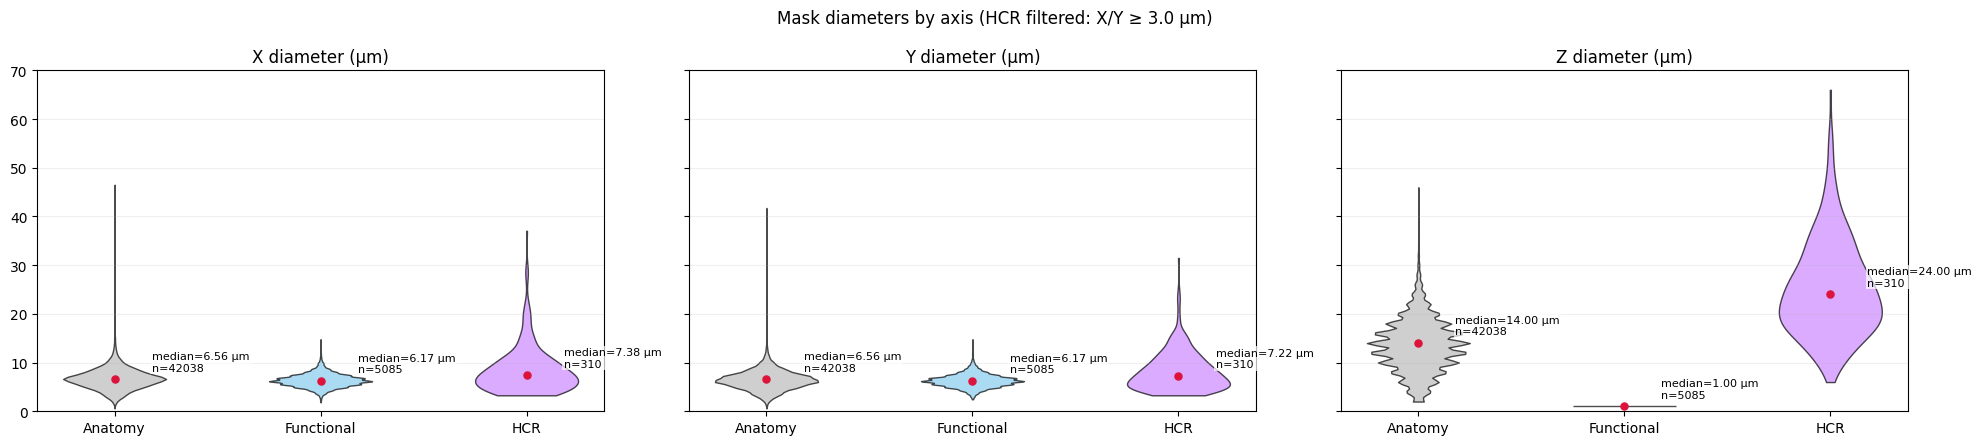

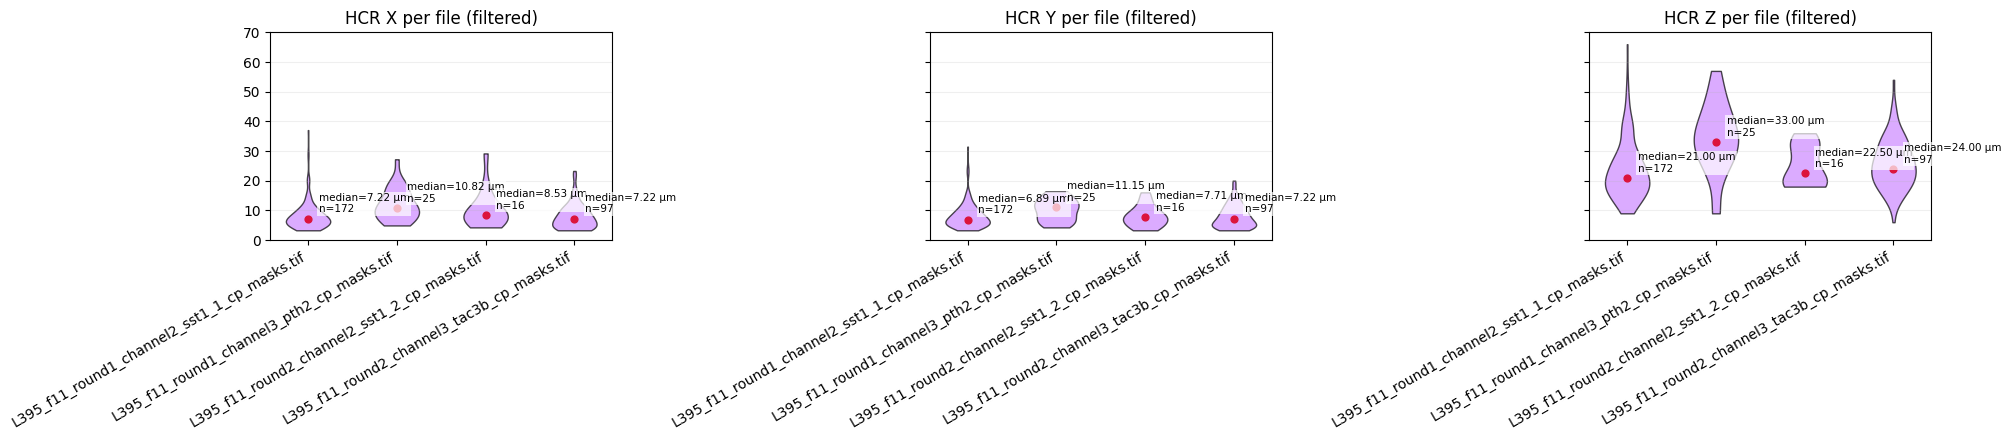

Outlier diameters after HCR filter (IQR fence, pooled), sorted high→low (per-plane/per-file labels):


In [90]:
# [29]
# Noise-filtered diameters: drop HCR labels with X or Y diameter < 3 µm
import numpy as _np, matplotlib.pyplot as _plt
from pathlib import Path
import os
import pandas as pd

MIN_XY_HCR_UM = 3.0

# Try to reuse df_all from previous cell or cache
df_all = globals().get('df_all', None)
if (df_all is None or getattr(df_all, 'empty', True)) and os.path.exists(OUTDIR / 'diameters_df_all.pkl'):
    try:
        df_all = pd.read_pickle(OUTDIR / 'diameters_df_all.pkl')
        print('[Info] Loaded df_all from cache pickle')
    except Exception:
        df_all = None

if df_all is None or getattr(df_all, 'empty', True):
    print('No label volumes available for noise-filtered diameter analysis. Run the previous diameters cell first.')
else:
    # Filter HCR by X/Y diameter >= threshold
    df_f = df_all.copy()
    if 'dataset' in df_f.columns:
        hcr_mask = df_f['dataset'].eq('HCR') if 'HCR' in df_f['dataset'].unique() else None
        if hcr_mask is not None:
            drop_mask = hcr_mask & ((df_f['x_um'] < MIN_XY_HCR_UM) | (df_f['y_um'] < MIN_XY_HCR_UM))
            if drop_mask.any():
                print(f"[Filter] Dropping {int(drop_mask.sum())} HCR labels with X or Y < {MIN_XY_HCR_UM} µm")
                df_f = df_f.loc[~drop_mask].reset_index(drop=True)
    df_all_filt = df_f
    cats_plot = ['Anatomy','Functional','HCR']
    present = [c for c in cats_plot if c in df_all_filt['dataset'].unique()]

    def _series_for_axis(axis_col, df):
        ser = []
        for ds in present:
            vals = df.loc[df['dataset']==ds, axis_col].to_numpy(dtype=float)
            ser.append(vals)
        return ser

    series_x = _series_for_axis('x_um', df_all_filt)
    series_y = _series_for_axis('y_um', df_all_filt)
    series_z = _series_for_axis('z_um', df_all_filt)

    all_vals = _np.concatenate([a for a in (series_x + series_y + series_z) if a.size]) if any((a.size for a in (series_x + series_y + series_z))) else _np.array([])
    y_max_data = float(_np.max(all_vals)) if all_vals.size else 10.0
    from math import ceil as _ceil
    y_max = max(10.0, 10.0 * _ceil(y_max_data / 10.0))
    yticks = _np.arange(0.0, y_max + 0.1, 10.0)

    color_map = {'Anatomy':'#bbbbbb', 'Functional':'#88ccee', 'HCR':'#cc88ff'}
    colors = [color_map.get(ds, '#cccccc') for ds in present]

    fig, axes = _plt.subplots(1, 3, figsize=(20, 4.5), sharey=True)
    if not hasattr(axes, '__len__'):
        axes = [axes]
    axis_cols = ['x_um', 'y_um', 'z_um']
    for ax, ser, title, axis_col in zip(axes, [series_x, series_y, series_z], ['X diameter (µm)', 'Y diameter (µm)', 'Z diameter (µm)'], axis_cols):
        if not any(a.size for a in ser):
            ax.set_visible(False)
            continue
        parts = ax.violinplot(ser, showmeans=False, showmedians=False, showextrema=False)
        for i, pc in enumerate(parts['bodies']):
            pc.set_facecolor(colors[i])
            pc.set_edgecolor('black')
            pc.set_alpha(0.7)
        x_offset = 0.18
        y_offset = 0.02 * y_max
        bbox_style = dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1.0)
        for i, vals in enumerate(ser, start=1):
            if vals.size:
                med = float(_np.median(vals))
                ax.scatter([i], [med], color='crimson', zorder=3, s=26)
                label_txt = 'median={:.2f} µm\nn={:d}'.format(med, vals.size)
                ax.text(i + x_offset, med + y_offset, label_txt,
                        va='bottom', ha='left', fontsize=8, bbox=bbox_style, clip_on=False, zorder=4)
        ax.set_title(title)
        ax.set_xticks(range(1, len(present)+1))
        ax.set_xticklabels(present, rotation=0)
        ax.set_ylim(0, y_max)
        ax.set_yticks(yticks)
        ax.grid(axis='y', alpha=0.2)
    fig.suptitle(f"Mask diameters by axis (HCR filtered: X/Y ≥ {MIN_XY_HCR_UM} µm)")
    _plt.tight_layout()
    _plt.show()

    # HCR per-file diameters (filtered)
    if 'HCR' in present and 'file' in df_all_filt.columns and df_all_filt.loc[df_all_filt['dataset']=='HCR', 'file'].notna().any():
        hcr_sub = df_all_filt[df_all_filt['dataset']=='HCR'].copy()
        hcr_files = list(hcr_sub['file'].dropna().unique())
        if hcr_files:
            fig2, axes2 = _plt.subplots(1, 3, figsize=(20, 4.5), sharey=True)
            if not hasattr(axes2, '__len__'):
                axes2 = [axes2]
            for ax, axis_col in zip(axes2, axis_cols):
                ser = [hcr_sub.loc[hcr_sub['file']==fn, axis_col].to_numpy(dtype=float) for fn in hcr_files]
                if not any(a.size for a in ser):
                    ax.set_visible(False)
                    continue
                parts = ax.violinplot(ser, showmeans=False, showmedians=False, showextrema=False)
                for pc in parts['bodies']:
                    pc.set_facecolor('#cc88ff')
                    pc.set_edgecolor('black')
                    pc.set_alpha(0.7)
                x_offset = 0.12
                y_offset = 0.02 * y_max
                for i, vals in enumerate(ser, start=1):
                    if vals.size:
                        med = float(_np.median(vals))
                        ax.scatter([i], [med], color='crimson', zorder=3, s=24)
                        ax.text(i + x_offset, med + y_offset,
                                f"median={med:.2f} µm\nn={vals.size}",
                                va='bottom', ha='left', fontsize=7.5,
                                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1.0),
                                clip_on=False, zorder=4)
                ax.set_title(f"HCR {axis_col.split('_')[0].upper()} per file (filtered)")
                ax.set_xticks(range(1, len(hcr_files)+1))
                ax.set_xticklabels(hcr_files, rotation=30, ha='right')
                ax.set_ylim(0, y_max)
                ax.set_yticks(yticks)
                ax.grid(axis='y', alpha=0.2)
            _plt.tight_layout()
            _plt.show()

    axis_name_map = {'x_um':'X', 'y_um':'Y', 'z_um':'Z'}
    outlier_rows = []
    for ds in present:
        sub = df_all_filt[df_all_filt['dataset']==ds]
        if sub.empty:
            continue
        for axis_col in axis_cols:
            vals = sub[axis_col].to_numpy(dtype=float)
            if not len(vals):
                continue
            try:
                q1, q3 = _np.percentile(vals, [25, 75])
                iqr = q3 - q1
                lo = q1 - 1.5*iqr
                hi = q3 + 1.5*iqr
            except Exception:
                lo, hi = -_np.inf, _np.inf
            outs = sub[(sub[axis_col] < lo) | (sub[axis_col] > hi)]
            if outs.empty:
                continue
            for _, row in outs.iterrows():
                entry = {
                    'dataset': ds,
                    'axis': axis_name_map.get(axis_col, axis_col),
                    'diameter_um': float(row[axis_col])
                }
                if 'label' in row and not pd.isna(row['label']):
                    entry['label'] = int(row['label'])
                if ds == 'Functional' and 'plane_idx' in row and not pd.isna(row['plane_idx']):
                    entry['plane_idx'] = int(row['plane_idx'])
                if 'file' in row and not pd.isna(row['file']):
                    entry['file'] = row['file']
                outlier_rows.append(entry)

    if outlier_rows:
        out_df = pd.DataFrame(outlier_rows).sort_values(
            ['dataset','axis','diameter_um'],
            ascending=[True, True, False]
        ).reset_index(drop=True)
        print('Outlier diameters after HCR filter (IQR fence, pooled), sorted high→low (per-plane/per-file labels):')
        try:
            from IPython.display import HTML, display
            html = out_df.to_html(index=False)
            display(HTML(f"<div style='max-height:320px; overflow-y:auto'>{html}</div>"))
        except Exception:
            print(out_df.to_string(index=False))
    else:
        print('No diameter outliers found after filter.')


### [15] Diagnostic: functional mask voxel assumptions vs pixel-scale diameters
Compare voxel-based and pixel-based mask diameter assumptions.

In [91]:
# [31]

# Diagnostic: functional mask voxel assumptions vs pixel-scale diameters
try:
    func_labels = None
    # Try cellpose masks first
    _cp_masks = []
    for pr in plane_refs:
        lbl = pr.get('label', None)
        if not lbl:
            continue
        mp = OUTDIR / f"{lbl}_cellpose_masks.tif"
        if mp.exists():
            _cp_masks.append(imread(mp))
    if _cp_masks:
        func_labels = _np.stack(_cp_masks, axis=0)
        source = 'cellpose masks'
    elif FUNC_LABELS_PATH and os.path.exists(FUNC_LABELS_PATH):
        func_labels = imread(FUNC_LABELS_PATH)
        source = f'FUNC_LABELS_PATH: {FUNC_LABELS_PATH}'
    else:
        source = 'none'
    print('Functional labels source:', source)
    if func_labels is None:
        print('No functional labels available for diagnostic.')
    else:
        func_3d = func_labels if func_labels.ndim == 3 else func_labels[None, ...]
        vox_f = {
            'Z': 1.0,
            'Y': float(VOX_FUNC.get('Y',1.0)) if 'VOX_FUNC' in globals() and VOX_FUNC else 1.0,
            'X': float(VOX_FUNC.get('X',1.0)) if 'VOX_FUNC' in globals() and VOX_FUNC else 1.0,
        }
        print('VOX_FUNC used:', vox_f)
        df_um = diameters_um_from_array(func_3d, vox_f)
        df_px = diameters_um_from_array(func_3d, {'Z':1.0,'Y':1.0,'X':1.0})
        print('Median diameters (µm): X={:.2f}, Y={:.2f}, Z={:.2f}'.format(df_um['x_um'].median(), df_um['y_um'].median(), df_um['z_um'].median()))
        print('Median diameters (pixels): X={:.2f}, Y={:.2f}, Z={:.2f}'.format(df_px['x_um'].median(), df_px['y_um'].median(), df_px['z_um'].median()))
except Exception as e:
    import traceback; traceback.print_exc()
    print('Diagnostic failed:', e)

Functional labels source: cellpose masks
VOX_FUNC used: {'Z': 1.0, 'Y': 0.6166852, 'X': 0.6166852}
Median diameters (µm): X=191.79, Y=56.12, Z=5.00
Median diameters (pixels): X=311.00, Y=91.00, Z=5.00


### [16] Centroid distance QA (labels already in anatomy space)
Quantify centroid distances between functional labels and anatomy labels.

In [ ]:
# [34]
# 3.1a) Centroid distance QA
_has_planes = ('plane_refs' in globals() and plane_refs)
if not _has_planes:
    print('No planes available for centroid QA.')

# Preload anatomy labels if available
anat_labels_all = None
try:
    if ANAT_LABELS_PATH and os.path.exists(ANAT_LABELS_PATH):
        anat_labels_all = _ensure_uint_labels(imread(ANAT_LABELS_PATH))
except Exception as _e:
    print('Could not load anatomy labels for centroid QA:', _e)

# Cache per-plane link tables
_links_cache = {}
_plane_data_cache = {}
_global_data = None

# Font sizes for this QA plot
QA_LEGEND_FONTSIZE = 15
QA_YTICK_FONTSIZE = 15

def _load_func_labels_for_plane(p_idx):
    if _has_planes:
        lbl = plane_refs[p_idx].get('label', f'plane{p_idx}')
        cp_path = OUTDIR / f"{lbl}_cellpose_masks.tif"
        if cp_path.exists():
            return _ensure_uint_labels(imread(cp_path)), lbl, f"Cellpose masks: {cp_path}"
    if FUNC_LABELS_PATH and os.path.exists(FUNC_LABELS_PATH):
        arr = _ensure_uint_labels(imread(FUNC_LABELS_PATH))
        if arr.ndim == 3 and p_idx < arr.shape[0]:
            return arr[p_idx], f"FUNC_LABELS_PATH[{p_idx}]", FUNC_LABELS_PATH
        if arr.ndim == 2:
            return arr, 'FUNC_LABELS_PATH', FUNC_LABELS_PATH
        if arr.ndim > 2:
            return arr[...,0], 'FUNC_LABELS_PATH[...,0]', FUNC_LABELS_PATH
    return None, None, None


def _compute_links_for_plane(p_idx):
    if p_idx in _links_cache:
        return _links_cache[p_idx]
    if not _has_planes:
        return None
    p_idx = int(max(0, min(len(plane_refs)-1, p_idx)))
    pr = plane_refs[p_idx]
    plabel = pr.get('label', f'plane{p_idx}')
    cache_paths = []
    if plabel:
        cache_paths.append(OUTDIR / f"f2a_centroid_matches_{plabel}.csv")
    if p_idx == 0:
        cache_paths.append(OUTDIR / 'f2a_centroid_matches.csv')
    for cp in cache_paths:
        if os.path.exists(cp):
            try:
                df_cached = pd.read_csv(cp)
                _links_cache[p_idx] = df_cached
                return df_cached
            except Exception:
                pass
    func_labels, func_label_name, func_src = _load_func_labels_for_plane(p_idx)
    if func_labels is None:
        print(f"[3.1a] Missing functional labels for plane {plabel}")
        return None
    if func_labels.ndim == 3:
        func_labels = func_labels[...,0]
    if func_labels.ndim != 2:
        print(f"[3.1a] Unexpected func label shape for plane {plabel}: {func_labels.shape}")
        return None
    tform_for_qa = pr.get('tform', tform)
    best_z_for_qa = int(pr.get('best_z', best_z if 'best_z' in globals() else 0))
    anat_labels_z = None
    if anat_labels_all is not None:
        anat_labels_z = anat_labels_all[best_z_for_qa] if anat_labels_all.ndim == 3 else anat_labels_all
    if anat_labels_z is None:
        print(f"[3.1a] Missing anatomy labels for plane {plabel}")
        return None
    # Centroids and matching
    fdf = _regionprops_centroids_2d(func_labels)
    tx, ty = _apply_tform_points_xy(tform_for_qa, fdf['cx'].values, fdf['cy'].values)
    fdf['cx_t'] = tx; fdf['cy_t'] = ty
    adf = _regionprops_centroids_2d(anat_labels_z)
    F = fdf[['cx_t','cy_t']].to_numpy(); A = adf[['cx','cy']].to_numpy()
    if F.size == 0 or A.size == 0:
        _links_cache[p_idx] = pd.DataFrame(columns=['fx_anat_px','fy_anat_px','ax_px','ay_px','dist_px','dist_um'])
        return _links_cache[p_idx]
    d2 = ((F[:,None,:] - A[None,:,:])**2).sum(axis=2); D = np.sqrt(d2)
    from scipy.optimize import linear_sum_assignment as _lsa
    row_ind, col_ind = _lsa(D)
    MAX_LINK_DIST_PX = 50.0
    keep = D[row_ind, col_ind] <= MAX_LINK_DIST_PX
    row_ind = row_ind[keep]; col_ind = col_ind[keep]
    try:
        vox_x = float(VOX_ANAT.get('X', VOX_ANAT.get(2, VOX_ANAT.get('2', 1.0))))
        vox_y = float(VOX_ANAT.get('Y', VOX_ANAT.get(1, VOX_ANAT.get('1', 1.0))))
    except Exception:
        vox_x, vox_y = 1.0, 1.0
    links = []
    for r, c in zip(row_ind, col_ind):
        fxp, fyp = float(F[r,0]), float(F[r,1]); axp, ayp = float(A[c,0]), float(A[c,1])
        dist_px = float(D[r,c])
        dx_um = (fxp - axp) * vox_x; dy_um = (fyp - ayp) * vox_y
        dist_um = float(np.sqrt(dx_um*dx_um + dy_um*dy_um))
        links.append({'fx_anat_px': fxp, 'fy_anat_px': fyp, 'ax_px': axp, 'ay_px': ayp, 'dist_px': dist_px, 'dist_um': dist_um})
    df = pd.DataFrame(links)
    _links_cache[p_idx] = df
    if len(df):
        for cp in cache_paths:
            try:
                df.to_csv(cp, index=False)
            except Exception:
                pass
    return df


def _prepare_plane_data(p_idx):
    if p_idx in _plane_data_cache:
        return _plane_data_cache[p_idx]
    df = _compute_links_for_plane(p_idx)
    if df is None or not len(df):
        _plane_data_cache[p_idx] = None
        return None
    try:
        import numpy as _np
        d = df['dist_um'].to_numpy().astype(float)
        med = float(_np.median(d))
    except Exception:
        d = df['dist_um'].to_numpy().astype(float)
        med = float(np.median(d))
    pr = plane_refs[int(p_idx)] if _has_planes else {}
    label = pr.get('label', f'plane{p_idx}') if pr else f'plane{p_idx}'
    best_z_for_qa = int(pr.get('best_z', best_z if 'best_z' in globals() else 0)) if pr else int(best_z if 'best_z' in globals() else 0)
    try:
        bg = norm01(anat[int(best_z_for_qa)])
    except Exception:
        bg = None
    _plane_data_cache[p_idx] = {
        'df': df,
        'd': d,
        'med': med,
        'label': label,
        'best_z': best_z_for_qa,
        'bg': bg,
    }
    return _plane_data_cache[p_idx]


def _collect_global_data():
    global _global_data
    if _global_data is not None:
        return _global_data
    if not _has_planes:
        return None
    import numpy as _np
    all_d = []
    for p in range(len(plane_refs)):
        pdp = _prepare_plane_data(p)
        if pdp is not None and pdp.get('d') is not None and pdp['d'].size:
            all_d.append(pdp['d'])
    if not all_d:
        _global_data = None
        return None
    dcat = _np.concatenate(all_d).astype(float)
    _global_data = {'d': dcat, 'med': float(_np.median(dcat)), 'N': int(dcat.size)}
    return _global_data


if _has_planes:
    import numpy as _np, matplotlib.pyplot as _plt, ipywidgets as widgets
    plane_sl = widgets.IntSlider(value=0, min=0, max=max(0, len(plane_refs)-1), step=1, description='Plane', continuous_update=False)
    thr_sl = widgets.FloatSlider(value=0.0, min=0.0, max=10.0, step=0.1, description='Threshold (µm)', style={'description_width': '120px'}, layout=widgets.Layout(width='420px'))
    out = widgets.Output(); count_html = widgets.HTML()
    _state = {'plane': int(plane_sl.value)}

    def _render(threshold):
        pdata = _plane_data_cache.get(_state['plane'], None)
        if pdata is None:
            with out:
                out.clear_output(wait=True)
                print('No centroid matches to plot for this plane.')
            count_html.value = ''
            return
        d = pdata['d']; df = pdata['df']; med = pdata['med']; bg = pdata['bg']; label = pdata['label']; bz = pdata['best_z']
        gdata = _collect_global_data()
        dg = gdata['d'] if gdata is not None else None
        gmed = gdata['med'] if gdata is not None else None
        gN = int(gdata.get('N', dg.size if dg is not None else 0)) if gdata is not None else None
        N = int(d.size)
        with out:
            out.clear_output(wait=True)
            fig, (ax1, ax2, ax3) = _plt.subplots(1,3, figsize=(20,7), gridspec_kw={'width_ratios':[1,3,1]})
            vp = ax1.violinplot(d, showmeans=False, showmedians=False, showextrema=False)
            for pc in vp['bodies']:
                pc.set_facecolor('#88ccee'); pc.set_edgecolor('black'); pc.set_alpha(0.7)
            ax1.axhline(med, color='crimson', linestyle='--', linewidth=1.5, label=f'Median {med:.2f} µm')
            ax1.axhline(float(threshold), color='orange', linestyle=':', linewidth=1.5, label=f'Thresh {float(threshold):.2f} µm')
            ax1.set_xticks([]); ax1.set_ylabel('Centroid distance (µm)'); ax1.set_title(f'Centroid distances (µm) — {label}'); ax1.legend(loc='lower right', fontsize=QA_LEGEND_FONTSIZE)
            ax1.tick_params(axis='y', labelsize=QA_YTICK_FONTSIZE)
            if bg is not None:
                ax2.imshow(bg, cmap='gray')
            keep_mask = d <= float(threshold); keep = int(keep_mask.sum())
            if keep and all(col in df.columns for col in ('ax_px','ay_px','fx_anat_px','fy_anat_px')):
                kept = df[keep_mask] if keep_mask.shape[0] == len(df) else df
                ax2.scatter(kept['ax_px'], kept['ay_px'], s=30, c='magenta', label='Anat centroids')
                ax2.scatter(kept['fx_anat_px'], kept['fy_anat_px'], s=30, facecolors='none', edgecolors='lime', label='Func→Anat centroids')
                for _, row in kept.iterrows():
                    ax2.plot([row['ax_px'], row['fx_anat_px']], [row['ay_px'], row['fy_anat_px']], 'y-', alpha=0.5)
                ax2.legend(loc='lower right', fontsize=QA_LEGEND_FONTSIZE)
            ax2.set_title(f'Kept links (≤ threshold) on anatomy — {label} @ Z={bz}'); ax2.axis('off')
            if dg is not None and dg.size:
                vp_g = ax3.violinplot(dg, showmeans=False, showmedians=False, showextrema=False)
                for pc in vp_g['bodies']:
                    pc.set_facecolor('#b3d9ff'); pc.set_edgecolor('black'); pc.set_alpha(0.7)
                if gmed is not None:
                    ax3.axhline(gmed, color='crimson', linestyle='--', linewidth=1.5, label=f'Global median {gmed:.2f} µm')
                ax3.axhline(float(threshold), color='orange', linestyle=':', linewidth=1.5, label=f'Thresh {float(threshold):.2f} µm')
                ax3.set_xticks([])
                ax3.set_ylabel('Centroid distance (µm)')
                ttl = 'All planes' if gN is None else f'All planes (N={gN})'
                ax3.set_title(ttl)
                ax3.legend(loc='lower right', fontsize=QA_LEGEND_FONTSIZE)
            ax3.set_ylim(ax1.get_ylim())
            ax3.tick_params(axis='y', labelsize=QA_YTICK_FONTSIZE)
            _plt.tight_layout(); _plt.show()
            count_html.value = f"<b>Plane:</b> {label} | <b>Best Z:</b> {bz} | <b>Keep:</b> {keep} / {N} cells (≤ {float(threshold):.2f} µm)"

    def _on_thr(change):
        if change.get('name') == 'value':
            _render(change['new'])

    def _ensure_plane_settings(p_idx):
        pdata = _prepare_plane_data(p_idx)
        if pdata is None:
            return None
        d = pdata['d']
        if d.size:
            thr_max = float(_np.percentile(d, 99))
            thr_val = float(_np.percentile(d, 90))
        else:
            thr_max = 10.0; thr_val = 0.0
        try:
            thr_sl.unobserve(_on_thr, names='value')
        except Exception:
            pass
        thr_sl.min = 0.0
        thr_sl.max = max(1.0, thr_max)
        thr_sl.value = min(thr_sl.max, max(thr_sl.min, thr_val))
        thr_sl.observe(_on_thr, names='value')
        return pdata

    def _on_plane(change):
        if change.get('name') == 'value':
            _state['plane'] = int(change['new'])
            # reset global cache when switching plane list may change
            _render_reset_global()

    def _render_reset_global():
        global _global_data
        _global_data = None
        pdata = _ensure_plane_settings(_state['plane'])
        _render(thr_sl.value if pdata is not None else 0.0)

    plane_sl.observe(_on_plane, names='value')
    thr_sl.observe(_on_thr, names='value')

    _render_reset_global()
    ui = widgets.VBox([widgets.HBox([plane_sl, thr_sl]), count_html, out])
    display(ui)
else:
    print('No plane_refs for centroid QA.')


### [16b] All-plane centroid distances (no threshold)
Plot the combined centroid distance distribution across all planes with the median indicated.


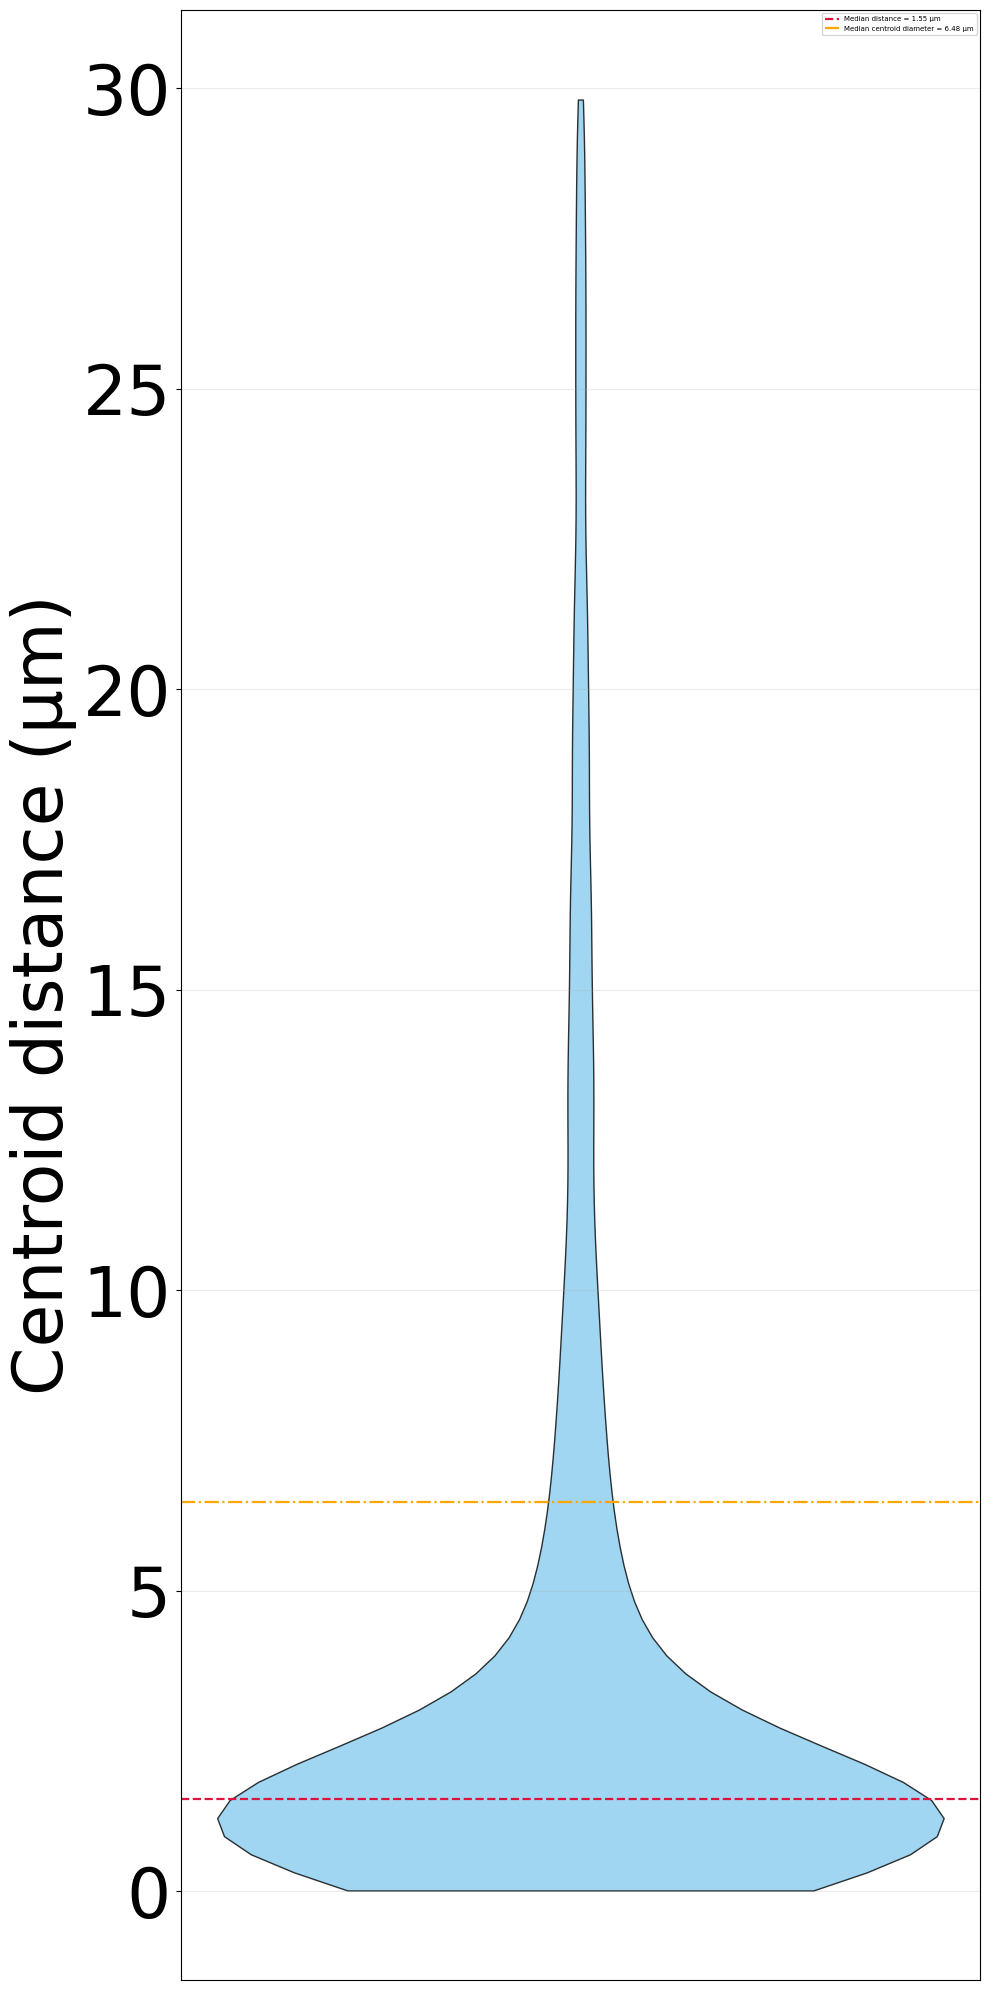

In [119]:
# [16b]
# Aggregate centroid distances across all planes (no distance gating) as a violin plot
import numpy as np
import matplotlib.pyplot as _plt

# Tuneable font sizes and figure size
VIOLIN_LEGEND_FONTSIZE = 10  # kept for compatibility (legend removed)
VIOLIN_YTICK_FONTSIZE = 10
VIOLIN_FIGSIZE = (6, 6)


def _collect_all_plane_centroid_dists():
    if 'plane_refs' not in globals() or not plane_refs:
        return None, 'No plane_refs available.'
    if '_collect_global_data' in globals():
        try:
            gd = _collect_global_data()
            if gd and gd.get('d') is not None and gd['d'].size:
                return np.asarray(gd['d'], dtype=float), None
        except Exception:
            pass
    if '_prepare_plane_data' not in globals():
        return None, 'Centroid QA helpers not initialized; run the previous QA cell first.'
    all_d = []
    for p in range(len(plane_refs)):
        pdp = _prepare_plane_data(p)
        if pdp and pdp.get('d') is not None and pdp['d'].size:
            all_d.append(np.asarray(pdp['d'], dtype=float))
    if not all_d:
        return None, 'No centroid matches available to plot.'
    return np.concatenate(all_d).astype(float), None


def _median_centroid_diameter_um():
    df_src = globals().get('df_all_filt', None)
    if df_src is None or getattr(df_src, 'empty', True):
        df_src = globals().get('df_all', None)
        if (df_src is None or getattr(df_src, 'empty', True)) and os.path.exists(OUTDIR / 'diameters_df_all.pkl'):
            try:
                df_src = pd.read_pickle(OUTDIR / 'diameters_df_all.pkl')
            except Exception:
                df_src = None
    if df_src is None or getattr(df_src, 'empty', True):
        return None, 'No diameter dataframe available (run diameters cell [13]/[14]).'
    if 'dataset' not in df_src.columns:
        return None, 'Diameter table missing dataset column.'
    df_func = df_src[df_src['dataset'] == 'Functional']
    if df_func.empty or not {'x_um', 'y_um'}.issubset(df_func.columns):
        return None, 'Functional XY diameters unavailable.'
    diam_xy = df_func[['x_um', 'y_um']].mean(axis=1).to_numpy(dtype=float)
    if not diam_xy.size:
        return None, 'Functional XY diameters unavailable.'
    return float(np.median(diam_xy)), None


dists, err = _collect_all_plane_centroid_dists()
if err:
    print(err)
elif dists is None or not dists.size:
    print('No centroid distances to plot.')
else:
    med = float(np.median(dists))
    med_diam, diam_err = _median_centroid_diameter_um()
    if diam_err:
        print(diam_err)
    fig, ax = _plt.subplots(figsize=VIOLIN_FIGSIZE)
    vp = ax.violinplot([dists], showmeans=False, showmedians=False, showextrema=False)
    for pc in vp['bodies']:
        pc.set_facecolor('#88ccee')
        pc.set_edgecolor('black')
        pc.set_alpha(0.8)
    ax.axhline(med, color='crimson', linestyle='--', linewidth=1.6)
    if med_diam is not None:
        ax.axhline(med_diam, color='orange', linestyle='-.', linewidth=1.6)
    ax.set_xticks([])
    ax.grid(axis='y', alpha=0.25)
    ax.tick_params(axis='y', labelsize=VIOLIN_YTICK_FONTSIZE)
    ax.set_yticklabels(ax.get_yticks(), fontsize=VIOLIN_YTICK_FONTSIZE)
    _plt.tight_layout()
    _plt.show()


### [17] Confocal masks via `best_rounds.csv` (ANTs transforms)
Build a manifest of confocal masks and transform chains from metadata.

In [94]:
# [39]
from pathlib import Path
import pandas as pd

BEST_ROUNDS_CSV = Path("/Volumes/jlarsch/default/D2c/07_Data/Danin/best_rounds.csv")
NAS_ROOT = Path("/Volumes/jlarsch/default/D2c/07_Data")
MANIFEST_OUT = Path("/Volumes/jlarsch/default/D2c/07_Data/Danin/confocal_mask_manifest.csv")
MASK_GLOB = "03_analysis/confocal/masks/*round{round_idx}*_cp_masks.tif"
# Override per fish/round if filenames differ (e.g., Cellpose). Example structure:
# HARDCODED_MASKS = {
#     "L395_f11": {
#         1: ["/path/to/L395_f11_round1_mask.tif"],
#         2: ["/path/to/L395_f11_round2_mask.nrrd"],
#     }
# }
HARDCODED_MASKS = {}

def owner_root(nas_root, owner):
    base = Path(nas_root) / owner
    mic = base / "Microscopy"
    return mic if mic.exists() else base

def find_transform_pair(fish_dir, src_round, target_tags):
    tm_root = fish_dir / "02_reg"
    candidates = sorted(tm_root.glob("**/transMatrices/*"), key=lambda p: p.stat().st_mtime, reverse=True)
    src_token = f"round{src_round}"
    warp = affine = None
    for f in candidates:
        name = f.name.lower()
        if src_token not in name:
            continue
        if not any(tag in name for tag in target_tags):
            continue
        if "inverse" in name:
            continue
        if ("warp" in name) and name.endswith(".nii.gz") and warp is None:
            warp = f
        if ("affine" in name) and f.suffix == ".mat" and affine is None:
            affine = f
        if warp and affine:
            break
    return warp, affine

def build_manifest_rows(best_row):
    fish_id = str(best_row.fish_id)
    best_round = str(best_row.best_round).lower()
    best_idx = int(best_round.lstrip("r"))
    num_rounds = int(best_row.num_rounds)
    owner = str(best_row.owner)
    fish_dir = owner_root(NAS_ROOT, owner) / fish_id
    ref = fish_dir / "02_reg" / "00_preprocessing" / "2p_anatomy" / f"{fish_id}_anatomy_2P_GCaMP.nrrd"
    if not ref.exists():
        print(f"[WARN] Missing 2P anatomy for {fish_id}")
        return []
    best2p_warp, best2p_aff = find_transform_pair(fish_dir, best_idx, target_tags=["2p", "ref"])
    if not (best2p_warp and best2p_aff):
        print(f"[WARN] Missing best->2p transforms for {fish_id} ({best_round})")
        return []
    rows = []
    overrides = HARDCODED_MASKS.get(fish_id, {})
    for round_idx in range(1, num_rounds + 1):
        if round_idx in overrides:
            masks = []
            for p in overrides[round_idx]:
                p = Path(p)
                if p.exists():
                    masks.append(p)
                else:
                    print(f"[WARN] Override mask missing for {fish_id} round {round_idx}: {p}")
        else:
            masks = list(fish_dir.glob(MASK_GLOB.format(round_idx=round_idx)))
        if not masks:
            print(f"[WARN] No masks found for {fish_id} round {round_idx}")
            continue
        if round_idx != best_idx:
            r_to_best = find_transform_pair(fish_dir, round_idx, target_tags=[f"r{best_idx}", f"round{best_idx}"])
            if not all(r_to_best):
                print(f"[WARN] Missing r{round_idx}->r{best_idx} transforms for {fish_id}")
                continue
        for mask in masks:
            out_dir = mask.parent / "aligned"
            out_dir.mkdir(parents=True, exist_ok=True)
            out_path = out_dir / f"{mask.stem}_in_2p{mask.suffix}"
            transform_chain = [best2p_warp, best2p_aff]
            if round_idx != best_idx:
                transform_chain += [r_to_best[0], r_to_best[1]]
            rows.append({
                "moving": str(mask),
                "reference": str(ref),
                "transforms": "; ".join(str(t) for t in transform_chain if t),
                "output": str(out_path),
                "fish_id": fish_id,
                "label": f"r{round_idx}_to_2p_via_r{best_idx}"
            })
    return rows

best_df = pd.read_csv(BEST_ROUNDS_CSV)
required = {"fish_id", "best_round", "num_rounds", "owner"}
missing = required - set(best_df.columns)
if missing:
    raise ValueError(f"best_rounds.csv missing columns: {missing}")

manifest_rows = []
for row in best_df.itertuples():
    manifest_rows.extend(build_manifest_rows(row))

manifest_df = pd.DataFrame(manifest_rows)
print(f"[INFO] built {len(manifest_df)} manifest rows")
if not manifest_df.empty:
    MANIFEST_OUT.parent.mkdir(parents=True, exist_ok=True)
    manifest_df.to_csv(MANIFEST_OUT, index=False)
    display(manifest_df.head())
else:
    print("[WARN] Manifest is empty; check warnings above.")

[INFO] built 4 manifest rows


moving  \
0  /Volumes/jlarsch/default/D2c/07_Data/Matilde/M...   
1  /Volumes/jlarsch/default/D2c/07_Data/Matilde/M...   
2  /Volumes/jlarsch/default/D2c/07_Data/Matilde/M...   
3  /Volumes/jlarsch/default/D2c/07_Data/Matilde/M...   

                                           reference  \
0  /Volumes/jlarsch/default/D2c/07_Data/Matilde/M...   
1  /Volumes/jlarsch/default/D2c/07_Data/Matilde/M...   
2  /Volumes/jlarsch/default/D2c/07_Data/Matilde/M...   
3  /Volumes/jlarsch/default/D2c/07_Data/Matilde/M...   

                                          transforms  \
0  /Volumes/jlarsch/default/D2c/07_Data/Matilde/M...   
1  /Volumes/jlarsch/default/D2c/07_Data/Matilde/M...   
2  /Volumes/jlarsch/default/D2c/07_Data/Matilde/M...   
3  /Volumes/jlarsch/default/D2c/07_Data/Matilde/M...   

                                              output   fish_id  \
0  /Volumes/jlarsch/default/D2c/07_Data/Matilde/M...  L395_f11   
1  /Volumes/jlarsch/default/D2c/07_Data/Matilde/M...  L395_f11   
2  /Volumes/jlarsch/default/D2c/07_Data/Matilde/M...  L395_f11   
3  /Volumes/jlarsch/default/D2c/07_Data/Matilde/M...  L395_f11   

             label  
0  r1_to_2p_via_r2  
1  r1_to_2p_via_r2  
2  r2_to_2p_via_r2  
3  r2_to_2p_via_r2

### [18] Save a small JSON with parameters and results
Persist run metadata and parameters to JSON for reuse.

In [95]:
# [43]

meta = {
    "FUNC_STACK_PATH": str(FUNC_STACK_PATH) if 'FUNC_STACK_PATH' in globals() and FUNC_STACK_PATH else None,
    "ANAT_STACK_PATH": str(ANAT_STACK_PATH) if 'ANAT_STACK_PATH' in globals() and ANAT_STACK_PATH else None,
    "HCR_STACK_PATH": str(HCR_STACK_PATH) if 'HCR_STACK_PATH' in globals() and HCR_STACK_PATH else None,
    "best_z": int(best_z),
    "transform_params_2x3": tform.params.tolist(),
    "ref_build_strategy": str(REF_BUILD_STRATEGY) if 'REF_BUILD_STRATEGY' in globals() else None,
    "voxels": {"func": VOX_FUNC, "anat": VOX_ANAT, "hcr": VOX_HCR},
    "voxel_cache": str(VOX_CACHE_PATH) if 'VOX_CACHE_PATH' in globals() else None,
    "rng_seed": RNG_SEED,
}

with open(OUTDIR/'run_metadata.json', 'w') as f:
    json.dump(meta, f, indent=2)

print("Wrote", OUTDIR/'run_metadata.json')

Wrote /Volumes/jlarsch/default/D2c/07_Data/Danin/L395_f11/03_analysis/functional/run_metadata.json


### [19] [HCR→2P] Config and transform discovery (ANTsPy)
Load best-round metadata and locate transforms/paths for HCR→2P warps.

In [96]:
# HCR→2P configuration (uses ANTsPy; mirrors antsQC defaults)
import re, json
from pathlib import Path
import pandas as pd

BEST_ROUNDS_CSV = Path("/Volumes/jlarsch/default/D2c/07_Data/Danin/best_rounds.csv")
BEST_ROUND_OVERRIDE = globals().get("BEST_ROUND_OVERRIDE", None)

HCR_CP_MASK_DIR = FISH_DIR / "03_analysis" / "confocal" / "cp_masks"
HCR_ALIGNED_DIR = FISH_DIR / "03_analysis" / "confocal" / "aligned"
HCR_ALIGNED_DIR.mkdir(parents=True, exist_ok=True)

PREPROC_DIR = FISH_DIR / "02_reg" / "00_preprocessing"
RBEST_TM_DIR = FISH_DIR / "02_reg" / "01_rbest-2p" / "transMatrices"
RN_TO_RBEST_TM_DIR = FISH_DIR / "02_reg" / "02_rn-rbest" / "transMatrices"
ANAT_INT_PATH = PREPROC_DIR / "2p_anatomy" / f"{FISH_ID}_anatomy_2P_GCaMP.nrrd"

MATCH_METHOD = globals().get("MATCH_METHOD", "nn")
MAX_DISTANCE_UM = float(globals().get("MAX_DISTANCE_UM", 10))
REQUIRE_OVERLAP = bool(globals().get("REQUIRE_OVERLAP", True))
MIN_OVERLAP_VOXELS = int(globals().get("MIN_OVERLAP_VOXELS", 1))
DEDUP_BY_TWOP = globals().get("DEDUP_BY_TWOP", "max_overlap")
IOU_MIN = float(globals().get("IOU_MIN", 0.05))
USE_FRAC_FILTERS = bool(globals().get("USE_FRAC_FILTERS", False))
MIN_OVERLAP_FRAC_CONF = float(globals().get("MIN_OVERLAP_FRAC_CONF", 0.0))
MIN_OVERLAP_FRAC_TWOP = float(globals().get("MIN_OVERLAP_FRAC_TWOP", 0.0))
PLOT_USE_FINAL_1TO1 = bool(globals().get("PLOT_USE_FINAL_1TO1", True))
INVERT_AFFINE = bool(globals().get("INVERT_AFFINE", False))
FORCE_RECOMPUTE_WARP = bool(globals().get("FORCE_RECOMPUTE_WARP", False))


def _parse_round_from_name(path: Path):
    m = re.search(r"round(\d+)", path.name.lower())
    return int(m.group(1)) if m else None


def _load_best_round(fish_id: str):
    if BEST_ROUND_OVERRIDE is not None:
        val = str(BEST_ROUND_OVERRIDE).lower().lstrip("r")
        return int(val), None
    df = pd.read_csv(BEST_ROUNDS_CSV)
    row = df.loc[df["fish_id"] == fish_id]
    if row.empty:
        raise ValueError(f"No best round found for fish_id={fish_id} in {BEST_ROUNDS_CSV}")
    r = row.iloc[0]
    best_round = int(str(r["best_round"]).lower().lstrip("r"))
    num_rounds = int(r["num_rounds"])
    return best_round, num_rounds


def _find_intensity_for_round(round_idx: int):
    sub = PREPROC_DIR / ("rbest" if round_idx == best_round_idx else "rn")
    candidates = sorted(sub.glob("*"))
    chosen = None
    for p in candidates:
        name = p.name.lower()
        if f"round{round_idx}" in name and "channel1" in name and "gcamp" in name and p.suffix.lower() == ".nrrd":
            chosen = p
            break
    if chosen is None:
        hits = [p for p in candidates if f"round{round_idx}" in p.name.lower() and p.suffix.lower() == ".nrrd"]
        if hits:
            chosen = hits[0]
    return chosen


def _find_transform(trans_dir: Path, round_idx: int, target_tag: str, kind: str):
    if trans_dir is None or not trans_dir.exists():
        return None
    hits = []
    for p in sorted(trans_dir.glob("*")):
        name = p.name.lower()
        if f"round{round_idx}" not in name:
            continue
        if target_tag not in name:
            continue
        if "inverse" in name:
            continue
        if kind == "warp" and name.endswith("warp.nii.gz"):
            hits.append(p)
        if kind == "affine" and name.endswith(".mat"):
            hits.append(p)
    return hits[0] if hits else None


best_round_idx, num_rounds = _load_best_round(FISH_ID)
print(f"[HCR] fish={FISH_ID} best_round=r{best_round_idx} num_rounds={num_rounds}")
print(f"[HCR] ANAT_INT_PATH: {ANAT_INT_PATH}")
print(f"[HCR] RBEST_TM_DIR: {RBEST_TM_DIR}")
print(f"[HCR] RN_TO_RBEST_TM_DIR: {RN_TO_RBEST_TM_DIR}")


[HCR] fish=L395_f11 best_round=r2 num_rounds=2
[HCR] ANAT_INT_PATH: /Volumes/jlarsch/default/D2c/07_Data/Danin/L395_f11/02_reg/00_preprocessing/2p_anatomy/L395_f11_anatomy_2P_GCaMP.nrrd
[HCR] RBEST_TM_DIR: /Volumes/jlarsch/default/D2c/07_Data/Danin/L395_f11/02_reg/01_rbest-2p/transMatrices
[HCR] RN_TO_RBEST_TM_DIR: /Volumes/jlarsch/default/D2c/07_Data/Danin/L395_f11/02_reg/02_rn-rbest/transMatrices


### [20] [HCR→2P] Warp confocal masks to 2P (cached ANTsPy)
Warp HCR label masks (and optional intensities) into 2P space with caching.

In [97]:
# Warp confocal masks (one TIFF per input) into 2P anatomy space
import numpy as np, tifffile as tiff
from pathlib import Path
try:
    import ants  # type: ignore
    HAVE_ANTSPY = True
except Exception as e:
    HAVE_ANTSPY = False
    print("ANTsPy not available; HCR warps disabled.", e)

if HAVE_ANTSPY and not ANAT_INT_PATH.exists():
    raise FileNotFoundError(f"Fixed 2P anatomy intensity not found: {ANAT_INT_PATH}")

def _ants_clone_geometry(dst_img, like_img):
    dst_img.set_spacing(like_img.spacing); dst_img.set_origin(like_img.origin); dst_img.set_direction(like_img.direction); return dst_img

def warp_cache_candidates(save_basename: Path):
    return [Path(f"{save_basename}_labels_int32.npy"), Path(f"{save_basename}_labels_uint16.tif")]

def load_cached_warp(save_basename: Path):
    for c in warp_cache_candidates(save_basename):
        if c.exists():
            if c.suffix == ".npy": return np.load(c, mmap_mode="r"), c
            if c.suffix == ".tif": return tiff.imread(str(c)), c
    return None, None

def warp_metadata_path(save_basename: Path):
    return Path(f"{save_basename}_warp_meta.json")

def write_warp_metadata(save_basename: Path, metadata: dict):
    warp_metadata_path(save_basename).write_text(json.dumps(metadata, indent=2))

def warp_label_tiff_chain(tiff_path, mov_img_int, fix_img_int, transformlist, whichtoinvert, save_basename: Path):
    lab_zyx = tiff.imread(str(tiff_path))
    if lab_zyx.ndim != 3: raise ValueError(f"Expected 3D TIFF (ZYX); got shape {lab_zyx.shape}")
    lab_xyz = np.transpose(lab_zyx, (2,1,0)).astype(np.int32, copy=False)
    mov_label_img = ants.from_numpy(lab_xyz); _ants_clone_geometry(mov_label_img, mov_img_int)
    if mov_label_img.shape != mov_img_int.shape: raise RuntimeError(f"Label XYZ shape {mov_label_img.shape} != moving intensity shape {mov_img_int.shape}.")
    warped_xyz = ants.apply_transforms(fixed=fix_img_int, moving=mov_label_img, transformlist=[str(t) for t in transformlist], whichtoinvert=list(whichtoinvert), interpolator="nearestNeighbor").numpy().astype(np.int32, copy=False)
    warped_zyx = np.transpose(warped_xyz, (2,1,0))
    out_paths = {}
    if int(warped_zyx.max()) <= 65535:
        tif_path = Path(f"{save_basename}_labels_uint16.tif"); tiff.imwrite(tif_path, warped_zyx.astype(np.uint16)); out_paths["tif"] = tif_path
    else:
        npy_path = Path(f"{save_basename}_labels_int32.npy"); np.save(npy_path, warped_zyx); out_paths["npy"] = npy_path
    return warped_zyx, out_paths

def _invert_flags_for_chain(chain):
    return [bool(INVERT_AFFINE) if str(p).lower().endswith(".mat") else False for p in chain]

warp_results = []
if not HAVE_ANTSPY:
    print("ANTsPy missing; skip HCR warps.")
else:
    fix_img_int = ants.image_read(str(ANAT_INT_PATH))
    best_warp = _find_transform(RBEST_TM_DIR, best_round_idx, "to_2p", "warp")
    best_aff  = _find_transform(RBEST_TM_DIR, best_round_idx, "to_2p", "affine")
    if best_warp is None or best_aff is None:
        raise FileNotFoundError(f"Missing r{best_round_idx}->2P transforms in {RBEST_TM_DIR}")

    mask_paths = sorted(HCR_CP_MASK_DIR.glob("*round*_cp_masks*.tif"))
    if not mask_paths: print(f"[HCR] No confocal masks found in {HCR_CP_MASK_DIR}")
    intensity_paths = []
    if bool(globals().get("WARP_HCR_INTENSITY_QC", False)):
        manual_intensity = globals().get("HCR_INTENSITY_PATHS", None)
        if manual_intensity:
            intensity_paths = [Path(p) for p in manual_intensity]
        else:
            intensity_paths = sorted(list((PREPROC_DIR/"rbest").glob("*round*_channel*.nrrd")) + list((PREPROC_DIR/"rn").glob("*round*_channel*.nrrd")))
        manual_int_path = globals().get("MANUAL_INTENSITY_WARP_PATH", None)
        manual_int_round = globals().get("MANUAL_INTENSITY_WARP_ROUND", None)
        if manual_int_path:
            intensity_paths.append(Path(manual_int_path))
            print(f"[HCR] Manual intensity path requested (round {manual_int_round}): {manual_int_path}")
        print(f"[HCR] Intensity QC enabled; {len(intensity_paths)} stack(s) found:")
        for ip in intensity_paths: print("   ", ip)

    for mp in mask_paths:
        rnd = _parse_round_from_name(mp)
        if rnd is None: print("[HCR] Skip (no round in name):", mp); continue
        mov_int_path = _find_intensity_for_round(rnd)
        if mov_int_path is None or not mov_int_path.exists(): print(f"[HCR] Missing intensity NRRD for round {rnd}: {mov_int_path}"); continue
        mov_img_int = ants.image_read(str(mov_int_path))
        if rnd == best_round_idx:
            chain = [best_warp, best_aff]
        else:
            r_to_best_warp = _find_transform(RN_TO_RBEST_TM_DIR, rnd, f"to_r{best_round_idx}", "warp")
            r_to_best_aff  = _find_transform(RN_TO_RBEST_TM_DIR, rnd, f"to_r{best_round_idx}", "affine")
            chain = [best_warp, best_aff, r_to_best_warp, r_to_best_aff]  # warp before affine so ANTs applies affine then warp
        if any(c is None for c in chain): print(f"[HCR] Incomplete transform chain for round {rnd}; chain={chain}"); continue
        chain_flags = _invert_flags_for_chain(chain)
        save_base = HCR_ALIGNED_DIR / f"{mp.stem}_in_2p"
        cached, cached_src = load_cached_warp(save_base)
        if cached is not None and not FORCE_RECOMPUTE_WARP:
            warped = cached; out_paths = {"cache": cached_src}
        else:
            warped, out_paths = warp_label_tiff_chain(mp, mov_img_int, fix_img_int, chain, chain_flags, save_base)
            write_warp_metadata(save_base, {"mask": str(mp), "moving_intensity": str(mov_int_path), "fixed_intensity": str(ANAT_INT_PATH), "transforms": [str(t) for t in chain], "whichtoinvert": chain_flags, "best_round": int(best_round_idx), "round": int(rnd)})
        warp_results.append({"round": rnd, "mask_path": mp, "warped": warped, "warped_paths": out_paths, "save_base": save_base})
        print(f"[HCR] warped {mp.name} (round {rnd}) -> shape {warped.shape}")

    if intensity_paths:
        for ip in intensity_paths:
            ip_path = Path(ip)
            if not ip_path.exists(): print(f"[HCR] Intensity path missing, skip: {ip_path}"); continue
            rnd = None
            if manual_int_path and ip_path == Path(manual_int_path) and manual_int_round is not None:
                try: rnd = int(str(manual_int_round).lstrip('r'))
                except Exception: rnd = None
            if rnd is None: rnd = _parse_round_from_name(ip_path)
            if rnd is None: print(f"[HCR] Could not parse round from intensity path: {ip_path}"); continue
            if rnd == best_round_idx:
                chain = [best_warp, best_aff]
            else:
                r_to_best_warp = _find_transform(RN_TO_RBEST_TM_DIR, rnd, f"to_r{best_round_idx}", "warp")
                r_to_best_aff  = _find_transform(RN_TO_RBEST_TM_DIR, rnd, f"to_r{best_round_idx}", "affine")
                chain = [best_warp, best_aff, r_to_best_warp, r_to_best_aff]  # warp before affine so ANTs applies affine then warp
            if any(c is None for c in chain): print(f"[HCR] Incomplete chain for intensity {ip_path}"); continue
            chain_flags = _invert_flags_for_chain(chain)
            mov_img_int = ants.image_read(str(ip_path))
            warped_img = ants.apply_transforms(fixed=fix_img_int, moving=mov_img_int, transformlist=[str(t) for t in chain], whichtoinvert=list(chain_flags), interpolator="linear")
            out_path = HCR_ALIGNED_DIR / f"{ip_path.stem}_in_2p.nrrd"
            ants.image_write(warped_img, str(out_path))
            print(f"[HCR] warped intensity {ip_path.name} -> {out_path}")


[HCR] warped L395_f11_round1_channel2_sst1_1_cp_masks.tif (round 1) -> shape (216, 750, 750)
[HCR] warped L395_f11_round1_channel3_pth2_cp_masks.tif (round 1) -> shape (216, 750, 750)
[HCR] warped L395_f11_round2_channel2_sst1_2_cp_masks.tif (round 2) -> shape (216, 750, 750)
[HCR] warped L395_f11_round2_channel3_tac3b_cp_masks.tif (round 2) -> shape (216, 750, 750)


### [21] Matching + QC vs 2P anatomy labels (antsQC style)
Description pending for this step.

In [98]:
# Matching and QC for each warped mask
import numpy as np
import pandas as pd
import tifffile as tiff
from scipy.spatial import cKDTree
from scipy.optimize import linear_sum_assignment
from skimage.measure import regionprops_table

if not warp_results:
    print("[HCR] No warped masks to match.")
else:
    if ANAT_LABELS_PATH is None or not Path(ANAT_LABELS_PATH).exists():
        raise RuntimeError("ANAT_LABELS_PATH is missing; cannot run QC.")
    anat_labels = imread_any(ANAT_LABELS_PATH)
    anat_labels = _ensure_uint_labels(anat_labels)
    vox_anat_um = {
        "dz": float(VOX_ANAT.get("Z", 1.0)) if "VOX_ANAT" in globals() else 1.0,
        "dy": float(VOX_ANAT.get("Y", 1.0)) if "VOX_ANAT" in globals() else 1.0,
        "dx": float(VOX_ANAT.get("X", 1.0)) if "VOX_ANAT" in globals() else 1.0,
    }

    hcr_match_results = []
    for res in warp_results:
        conf_labels_2p = res["warped"]
        if conf_labels_2p.shape != anat_labels.shape:
            print(f"[HCR] Shape mismatch confocal vs anat: {conf_labels_2p.shape} vs {anat_labels.shape}")
            continue
        df_conf = compute_centroids(conf_labels_2p)
        df_2p = compute_centroids(anat_labels)
        P_conf_um = idx_to_um(df_conf, vox_anat_um)
        P_2p_um = idx_to_um(df_2p, vox_anat_um)

        labels_conf = df_conf["label"].to_numpy()
        labels_2p = df_2p["label"].to_numpy()

        if MATCH_METHOD == "nn":
            dists, nn = nearest_neighbor_match(P_conf_um, P_2p_um)
            matched_twoP_labels = labels_2p[nn]
            matched_conf_labels = labels_conf
        elif MATCH_METHOD == "hungarian":
            dists, col_ind, row_ind = hungarian_match(P_conf_um, P_2p_um, max_cost=np.inf)
            matched_conf_labels = labels_conf[row_ind]
            matched_twoP_labels = labels_2p[col_ind]
        else:
            raise ValueError('MATCH_METHOD must be "nn" or "hungarian"')

        valid = dists <= float(MAX_DISTANCE_UM)
        matches = pd.DataFrame({
            "conf_label": matched_conf_labels,
            "twoP_label": matched_twoP_labels,
            "distance_um": dists,
            "within_gate": valid
        }).sort_values("distance_um", ascending=True).reset_index(drop=True)

        conf_warped_labels = conf_labels_2p
        twoP_labels = anat_labels

        if REQUIRE_OVERLAP or DEDUP_BY_TWOP in {"closest", "max_overlap"}:
            overlap_df = compute_label_overlap(conf_warped_labels, twoP_labels, min_overlap_voxels=int(MIN_OVERLAP_VOXELS))
            matches = matches.merge(overlap_df[["conf_label", "twoP_label", "overlap_voxels"]], on=["conf_label", "twoP_label"], how="left")
            matches["overlap_voxels"] = matches["overlap_voxels"].fillna(0).astype(int)

            if REQUIRE_OVERLAP:
                matches["within_gate"] = matches["within_gate"] & (matches["overlap_voxels"] >= int(MIN_OVERLAP_VOXELS))

            if DEDUP_BY_TWOP in {"closest", "max_overlap"}:
                m = matches["within_gate"].to_numpy()
                if m.any():
                    sub = matches.loc[m].copy()
                    if DEDUP_BY_TWOP == "closest":
                        sub = sub.sort_values(["twoP_label", "distance_um"], ascending=[True, True])
                    else:
                        sub = sub.sort_values(["twoP_label", "overlap_voxels", "distance_um"], ascending=[True, False, True])
                    keep_idx = sub.drop_duplicates(subset=["twoP_label"], keep="first").index
                    drop_idx = sub.index.difference(keep_idx)
                    if len(drop_idx) > 0:
                        matches.loc[drop_idx, "within_gate"] = False

        matches = matches.sort_values("distance_um", ascending=True).reset_index(drop=True)

        def label_volumes(arr):
            labels, counts = np.unique(arr, return_counts=True)
            s = pd.Series(counts, index=labels)
            return s.drop(index=0, errors='ignore').astype(int)

        conf_vol_s = label_volumes(conf_warped_labels)
        twoP_vol_s = label_volumes(twoP_labels)

        matches['conf_vol'] = matches['conf_label'].map(conf_vol_s).fillna(0).astype(int)
        matches['twoP_vol'] = matches['twoP_label'].map(twoP_vol_s).fillna(0).astype(int)

        den = matches['conf_vol'] + matches['twoP_vol'] - matches['overlap_voxels']
        matches['iou'] = np.divide(matches['overlap_voxels'], den, out=np.zeros_like(den, dtype=float), where=(den > 0))
        matches['overlap_frac_conf'] = np.divide(matches['overlap_voxels'], matches['conf_vol'], out=np.zeros_like(matches['conf_vol'], dtype=float), where=(matches['conf_vol'] > 0))
        matches['overlap_frac_twoP'] = np.divide(matches['overlap_voxels'], matches['twoP_vol'], out=np.zeros_like(matches['twoP_vol'], dtype=float), where=(matches['twoP_vol'] > 0))

        acc = matches.loc[matches['within_gate']].copy()
        conf_counts = acc['conf_label'].value_counts()
        twop_counts = acc['twoP_label'].value_counts()

        def _pair_type(row):
            if not row['within_gate']:
                return 'rejected'
            cm = int(conf_counts.get(row['conf_label'], 0))
            tm = int(twop_counts.get(row['twoP_label'], 0))
            if cm == 1 and tm == 1: return '1-1'
            if cm > 1 and tm == 1:  return 'merge'
            if cm == 1 and tm > 1:  return 'split'
            return 'complex'

        matches['pair_type'] = matches.apply(_pair_type, axis=1)

        if USE_FRAC_FILTERS:
            ok_frac = (matches['overlap_frac_conf'] >= float(MIN_OVERLAP_FRAC_CONF)) & (matches['overlap_frac_twoP'] >= float(MIN_OVERLAP_FRAC_TWOP))
        else:
            ok_frac = True

        matches['quality'] = np.where(
            matches['within_gate'] & (matches['iou'] >= float(IOU_MIN)) & ok_frac, 'good',
            np.where(matches['within_gate'], 'iffy', 'rejected')
        )

        final_pairs = matches[(matches['pair_type'] == '1-1') & (matches['quality'] == 'good')].copy().sort_values(['distance_um', 'twoP_label'])
        review = matches[((matches['pair_type'].isin(['split','merge','complex'])) & matches['within_gate']) | ((matches['pair_type'] == '1-1') & (matches['quality'] != 'good'))].sort_values(['pair_type','iou','distance_um'], ascending=[True, False, True]).copy()

        gate_mask = (matches['distance_um'] <= float(MAX_DISTANCE_UM))
        if bool(REQUIRE_OVERLAP):
            gate_mask = gate_mask & (matches['overlap_voxels'] >= int(MIN_OVERLAP_VOXELS))

        qc = pd.Series({
            'gate_only_pairs': int(gate_mask.sum()),
            'accepted_pairs_after_dedup': int(matches['within_gate'].sum()),
            'final_1to1_good': int(final_pairs.shape[0]),
            'splits_among_accepted': int((matches['pair_type'] == 'split').sum()),
            'merges_among_accepted': int((matches['pair_type'] == 'merge').sum()),
            'complex_among_accepted': int((matches['pair_type'] == 'complex').sum()),
        }, name='QC Summary')

        save_base = res['save_base']
        matches_csv = Path(f"{save_base}_matches.csv")
        matches.to_csv(matches_csv, index=False)
        final_pairs.to_csv(Path(f"{save_base}_final_pairs.csv"), index=False)
        review.to_csv(Path(f"{save_base}_review.csv"), index=False)

        if PLOT_USE_FINAL_1TO1 and not final_pairs.empty:
            matches_for_plots = final_pairs.copy()
            key_final = set(map(tuple, matches_for_plots[['conf_label','twoP_label']].to_numpy()))
            accepted_mask = matches[['conf_label','twoP_label']].apply(tuple, axis=1).isin(key_final).to_numpy()
        else:
            matches_for_plots = matches.loc[matches['within_gate']].copy()
            accepted_mask = matches['within_gate'].to_numpy()

        dz_um = float(vox_anat_um['dz'])
        scope_df = matches_for_plots
        conf_ids = np.unique(scope_df['conf_label'].to_numpy(dtype=int)); conf_ids = conf_ids[conf_ids != 0]
        twoP_ids = np.unique(scope_df['twoP_label'].to_numpy(dtype=int)); twoP_ids = twoP_ids[twoP_ids != 0]

        conf_within_mask = np.isin(conf_warped_labels, conf_ids)
        twoP_within_mask = np.isin(twoP_labels, twoP_ids)

        tiff.imwrite(Path(f"{save_base}_conf_within_mask.tif"), (conf_within_mask.astype(np.uint8) * 255), imagej=True, metadata={'axes': 'ZYX', 'spacing': dz_um, 'unit': 'um'}, compression='deflate')
        tiff.imwrite(Path(f"{save_base}_twoP_within_mask.tif"), (twoP_within_mask.astype(np.uint8) * 255), imagej=True, metadata={'axes': 'ZYX', 'spacing': dz_um, 'unit': 'um'}, compression='deflate')

        conf_within_labels = np.where(conf_within_mask, conf_warped_labels, 0)
        twoP_within_labels = np.where(twoP_within_mask, twoP_labels, 0)

        def _min_unsigned_dtype(max_val: int):
            import numpy as _np
            if max_val <= _np.iinfo(_np.uint16).max:
                return _np.uint16
            elif max_val <= _np.iinfo(_np.uint32).max:
                return _np.uint32
            return _np.uint64

        conf_dtype = _min_unsigned_dtype(int(conf_within_labels.max()))
        twoP_dtype = _min_unsigned_dtype(int(twoP_within_labels.max()))
        conf_within_labels = conf_within_labels.astype(conf_dtype, copy=False)
        twoP_within_labels = twoP_within_labels.astype(twoP_dtype, copy=False)

        def _imwrite_with_meta(path, arr):
            import numpy as _np
            if arr.dtype in (_np.uint8, _np.uint16):
                tiff.imwrite(path, arr, imagej=True, metadata={'axes': 'ZYX', 'spacing': dz_um, 'unit': 'um'}, compression='deflate')
            else:
                tiff.imwrite(path, arr, compression='deflate')

        _imwrite_with_meta(Path(f"{save_base}_conf_within_labels.tif"), conf_within_labels)
        _imwrite_with_meta(Path(f"{save_base}_twoP_within_labels.tif"), twoP_within_labels)

        rgb = np.zeros(conf_within_mask.shape + (3,), dtype=np.uint8)
        rgb[..., 0] = np.where(conf_within_mask, 242, 0)
        rgb[..., 1] = np.where(conf_within_mask,  84, 0)
        rgb[..., 2] = np.where(conf_within_mask, 166, 0)
        rgb[..., 0] = np.clip(rgb[..., 0] + np.where(twoP_within_mask,  51, 0), 0, 255)
        rgb[..., 1] = np.clip(rgb[..., 1] + np.where(twoP_within_mask, 166, 0), 0, 255)
        rgb[..., 2] = np.clip(rgb[..., 2] + np.where(twoP_within_mask, 255, 0), 0, 255)
        tiff.imwrite(Path(f"{save_base}_within_gate_overlay_rgb.tif"), rgb, photometric='rgb', compression='deflate')

        summary = summarize_distances(matches['distance_um'].to_numpy(), matches['within_gate'].to_numpy())
        hcr_match_results.append({
            'round': res['round'],
            'mask_path': res['mask_path'],
            'matches': matches,
            'final_pairs': final_pairs,
            'review': review,
            'summary': summary,
            'qc': qc,
            'matches_csv': matches_csv,
            'df_conf': df_conf,
            'df_2p': df_2p,
            'P_conf_um': P_conf_um,
            'P_2p_um': P_2p_um,
        })

    best_round_matches = [r for r in hcr_match_results if r['round'] == best_round_idx]
    if best_round_matches:
        hcr_primary_matches = best_round_matches[0]['matches']
        hcr_primary_final_pairs = best_round_matches[0]['final_pairs']
        print(f"[HCR] Primary results from round r{best_round_idx}: {len(hcr_primary_final_pairs)} final pairs")
    else:
        hcr_primary_matches = None
        hcr_primary_final_pairs = None
        print("[HCR] No primary results (best round missing)")


[HCR] Primary results from round r2: 10 final pairs


### [22] [HCR→2P] 3D match viewer
Interactive 3D view (Plotly) of matched centroids per HCR mask/gene; dropdown selects the mask.

In [99]:
# 3D match viewer (Plotly) — per-mask dropdown by gene; masks + final-pair centroids
import plotly.graph_objects as go
import numpy as np
import re
from pathlib import Path
from skimage.measure import marching_cubes

if not hcr_match_results:
    print('[HCR] No match results to plot.')
else:
    twoP_labels_all = imread_any(ANAT_LABELS_PATH)
    twoP_labels_all = _ensure_uint_labels(twoP_labels_all)
    dz = float(VOX_ANAT.get('Z', 1.0)) if 'VOX_ANAT' in globals() else 1.0
    dy = float(VOX_ANAT.get('Y', 1.0)) if 'VOX_ANAT' in globals() else 1.0
    dx = float(VOX_ANAT.get('X', 1.0)) if 'VOX_ANAT' in globals() else 1.0

    def gene_from_mask_path(p: Path):
        name = p.name
        m = re.search(r"channel\d+_(.+?)_cp_masks", name)
        gene = m.group(1) if m else name
        return gene.replace('sst1_', 'sst1.')

    def build_surface(mask_bool):
        if not np.any(mask_bool):
            return np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([])
        verts, faces, _, _ = marching_cubes(mask_bool.astype(np.uint8), level=0.5, spacing=(dz, dy, dx))
        i, j, k = faces.T.astype(np.int32, copy=False)
        zc, yc, xc = verts[:, 0], verts[:, 1], verts[:, 2]
        return xc, yc, zc, i, j, k

    traces = []
    gene_spans = []

    for res in hcr_match_results:
        fp = res.get('final_pairs')
        matches_df = res.get('matches')
        if PLOT_USE_FINAL_1TO1 and fp is not None and not fp.empty:
            plot_df = fp
        elif matches_df is not None:
            plot_df = matches_df.loc[matches_df['within_gate']].copy()
        else:
            plot_df = None
        if plot_df is None or plot_df.empty:
            continue

        conf_labels = res.get('warped')
        if conf_labels is None:
            continue
        gene = gene_from_mask_path(Path(res['mask_path']))

        # Limit masks to labels that appear in the plotted pairs
        conf_ids = np.unique(plot_df['conf_label'].to_numpy(dtype=int))
        conf_ids = conf_ids[conf_ids > 0]
        twoP_ids = np.unique(plot_df['twoP_label'].to_numpy(dtype=int))
        twoP_ids = twoP_ids[twoP_ids > 0]
        conf_mask = np.isin(conf_labels, conf_ids)
        twoP_mask = np.isin(twoP_labels_all, twoP_ids)

        xC, yC, zC, iC, jC, kC = build_surface(conf_mask)
        xT, yT, zT, iT, jT, kT = build_surface(twoP_mask)

        # Centroids (in µm) for plotted pairs
        conf_cent = {int(lbl): (row['x']*dx, row['y']*dy, row['z']*dz) for lbl, row in res['df_conf'].set_index('label').iterrows()} if 'df_conf' in res else {}
        twop_cent = {int(lbl): (row['x']*dx, row['y']*dy, row['z']*dz) for lbl, row in res['df_2p'].set_index('label').iterrows()} if 'df_2p' in res else {}
        fx=[]; fy=[]; fz=[]; ax=[]; ay=[]; az=[]; lx=[]; ly=[]; lz=[]; htext=[]
        for _, row in plot_df.iterrows():
            c = conf_cent.get(int(row['conf_label'])); t = twop_cent.get(int(row['twoP_label']))
            if c is None or t is None:
                continue
            fx.append(c[0]); fy.append(c[1]); fz.append(c[2])
            ax.append(t[0]); ay.append(t[1]); az.append(t[2])
            lx += [c[0], t[0], None]; ly += [c[1], t[1], None]; lz += [c[2], t[2], None]
            htext.append(f"conf {int(row['conf_label'])} ↔ 2P {int(row['twoP_label'])}, d={row.get('distance_um',0):.2f} µm")

        start = len(traces)
        traces.extend([
            go.Mesh3d(x=xC, y=yC, z=zC, i=iC, j=jC, k=kC, name=f'{gene} mask', color='magenta', opacity=0.15, visible=False),
            go.Mesh3d(x=xT, y=yT, z=zT, i=iT, j=jT, k=kT, name='2P mask', color='cyan', opacity=0.10, visible=False),
            go.Scatter3d(x=fx, y=fy, z=fz, mode='markers', name='conf centroids', marker=dict(size=4, color='magenta'), visible=False),
            go.Scatter3d(x=ax, y=ay, z=az, mode='markers', name='2P centroids', marker=dict(size=4, color='cyan'), visible=False),
            go.Scatter3d(x=lx, y=ly, z=lz, mode='lines', name='pairs', line=dict(color='gray', width=2), visible=False, hoverinfo='text', text=htext),
        ])
        gene_spans.append((gene, start))

    if gene_spans:
        # Initial visibility: first gene
        visible = [False] * len(traces)
        visible[0:5] = [True, True, True, True, True]
        for i, tr in enumerate(traces):
            tr.visible = visible[i]

        # Dropdown buttons with full-length visibility arrays
        buttons = []
        for gene, start in gene_spans:
            vis = [False] * len(traces)
            vis[start:start+5] = [True, True, True, True, True]
            buttons.append(dict(label=gene, method='update', args=[{'visible': vis}, {'title': f'3D matches: {gene}'}]))

        fig = go.Figure(data=traces)
        fig.update_layout(
            width=1500, height=1500,
            title='3D matches',
            scene=dict(xaxis_title='X (µm)', yaxis_title='Y (µm)', zaxis_title='Z (µm)', aspectmode='data'),
            updatemenus=[dict(buttons=buttons, direction='down')]
        )
        fig.show()
    else:
        print('[HCR] No centroid matches to plot.')


[HCR] No centroid matches to plot.
